# Analyze computational descriptors from B3LYP DFT and TD-DFT, and CAM-B3LYP sTD-DFT to determine empirical model to predict FF, Jsc, Voc, and PCE

In [1]:
from __future__ import print_function

%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import math
import statistics
from scipy.stats import sem
from pathlib import Path

import statsmodels.api as sm

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.utils import check_consistent_length
from sklearn.utils import check_array
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

plt.style.use("seaborn-ticks") 
sns.set_context(context = "paper", font_scale = 2)

Reading in the csv with acceptor-donor pairs and DFT calculated properties

In [2]:
df = pd.read_csv('../data_csv/DFT_for_analysis.csv')
print("Number of acceptor-donor pairs is " + str(len(df.index)))

df_highPCE = pd.read_csv('../data_csv/DFT_for_analysis_highPCE.csv')
print("Number of acceptor-donor pairs with PCE greater than 9% is " + str(len(df_highPCE.index)))

Number of acceptor-donor pairs is 84
Number of acceptor-donor pairs with PCE greater than 9% is 59


In [3]:
DFTfields = {'AccHOMO': float, 'AccCalcLUMO': float, 'AccFundBg': float, 'AccOptBg': float, 'AccEnergyTransitioneV': float, 'AccTriplet': float, 
             'AccDeltaHOMO': float,'AccDeltaLUMO': float,'DeltaDipMom': float, 'GSDipMom': float,'AccEnergyTransitionWavenumber': float, 'AccOscStr': float, 
             'AccSumOscStr': float,'AccElectroIndex': float,'AccNucleoIndex':float, 'AccChemHard':float, 
             'AccElectrodonating':float, 'AccElectroaccepting':float,'PiSystemSize': float, 'Planarity': float, 'Polarizability': float,
             'DonHOMO': float, 'DonCalcLUMO': float, 'DonFundBg': float, 'DonEnergyTransitioneV': float, 'DonDeltaHOMO': float, 'DonDeltaLUMO': float,
             'DonEnergyTransitionWavenumber': float,'DonOscStr': float, 'DonSumOscStr': float,'DonElectroIndex': float, 'DonNucleoIndex': float,'DonChemHard':float,
             'DonElectrodonating':float, 'DonElectroaccepting':float,
             'AbsFOM': float,    'LUMOOffset': float, 'HOMOOffset': float, 'DHomoALumoOffset': float, 
             'acc_first_oscs': float, 'acc_highest_oscs_under_ten': float,'acc_lowest_transition_eV': float,
             'acc_lowest_transition_wavenumber': float,'don_first_oscs': float,'don_highest_oscs_under_ten': float,
             'don_lowest_transition_eV': float,'don_lowest_transition_wavenumber': float,
             'sTDDFTLUMO': float, 'sTDDFTHOMO': float, 'sTDDFTdeltaLUMO': float, 'sTDDFTdeltaHOMO': float, 'sTDDFToptbg': float, 
             'sTDDFToscs': float, 'sTDDFTfundbg': float, 'sTDDFTsinglepointenergy': float, 'sTDDFTdipolemoment': float, 'sTDDFTsummedoscs':float, 
             'sTDDFTabsFOM':float,'sTDDFTAccNucleoIndex':float,'sTDDFTaccElectrophilicity': float, 'sTDDFTAccChemHard': float, 
             'sTDDFTAccElectrodonating': float, 'sTDDFTAccElectroaccepting': float,
             'donsTDDFTLUMO': float,'donsTDDFTHOMO': float, 'sTDDFTDonNucleoIndex':float,'donsTDDFTdeltaLUMO': float, 'donsTDDFTdeltaHOMO': float, 
             'donsTDDFToptbg': float, 'donsTDDFToscs': float,'donsTDDFTfundbg': float, 'donsTDDFTsinglepointenergy': float, 'donsTDDFTdipolemoment': float,
             'donsTDDFTsummedoscs':float, 'donsTDDFTabsFOM':float,'sTDDFTDonChemHard': float, 
             'sTDDFTDonElectrodonating': float, 'sTDDFTDonElectroaccepting': float,'sTDDFTdonElectrophilicity': float,
             'sTDDFTDHomoALumoOffset':float,'sTDDFTHOMOoffset': float, 'sTDDFTLUMOoffset': float,
             'sTDDFTdonlowestengtranseV':float, 'sTDDFTdonlowestengtranswavenumber':float, 'sTDDFTdonfirstengtranseV':float, 'sTDDFTdonfirstengtranswavenumber':float, 'sTDDFTdonfirstoscs':float,
          'sTDDFTacclowestengtranseV':float, 'sTDDFTacclowestengtranswavenumber':float, 'sTDDFTaccfirstengtranseV':float, 'sTDDFTaccfirstengtranswavenumber':float, 'sTDDFTaccfirstoscs':float,
          'sTDDFTacchighestoscsunderten':float, 'sTDDFTdonhighestoscsunderten':float,
             'ScharberJsclowestoptbg': float,'ScharberVoc': float,'ScharberJscDon': float, 'ScharberJscAcc': float,'ScharberTotalJsc': float,
             'ScharberFF': float,'ScharberPCEtotal': float, 'ScharberPCEacc': float, 'ScharberPCEdon': float, 'ScharberPCElowestoptbg': float, 
             'sTDDFTScharberVoc': float, 'sTDDFTScharberJscDon': float, 'sTDDFTScharberJscAcc': float,'sTDDFTScharberJscTot': float, 
             'sTDDFTScharberPCETot': float,'sTDDFTScharberPCEAcc': float, 'sTDDFTScharberPCEDon': float,
             'ImamuraVoc': float,'ImamuraJscDon': float,'ImamuraJscAcc': float, 'ImamuraTotalJsc': float,'ImamuraFF': float,'ImamuraPCEtotal': float, 
             'ImamuraPCEacc': float, 'ImamuraPCEdon': float, 
             'AlharbiVocDon': float, 'AlharbiVocAcc': float, 'AlharbiFFDon': float, 'AlharbiFFAcc': float,'AlharbiPCEAcc': float, 'AlharbiPCEDon': float,
             'ExperimentalFF': float, 'ExperimentalVoc': float,'ExperimentalJsc': float, 'ExperimentalPCE': float}

df = df.astype(DFTfields)
df_highPCE = df_highPCE.astype(DFTfields)

#df.describe()

In [4]:

## from sci-kit-learn https://github.com/scikit-learn/scikit-learn/blob/4773f3e39/sklearn/metrics/_regression.py#L197
def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):

    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def evaluate_model(list_of_desc, target, dataframe, cf = False, output=True):
    '''
    list_of_desc = name of the list that contains the descriptors
    target = target experimental value in the dataframe. Ex: df_highPCE['ExperimentalJsc']
    dataframe = name of dataframe to use descriptors from
    cf = should it show the coefficients
    '''
    
    new_df = dataframe[list_of_desc].copy()
    
    max_mae = 10.0
    best_alpha = 0
    for a in range(1,200):
        lm =Lasso(alpha=float(a)/100.0)
        lm.fit(new_df, target)
        mae = mean_absolute_error(target, lm.predict(new_df))
        if mae < max_mae:
            best_alpha = float(a)/100.0
            max_mae = mae

    r2_score = []
    intercepts = []
    coefs = []
    predicted_PCE = []
    MAE_cv = []
    RMSE_cv = []

    PCE_cv = cross_validate(Lasso(alpha = best_alpha, max_iter = 100000), new_df, target, cv=5, scoring = ['neg_mean_squared_error'] , return_estimator = True)
    for x in PCE_cv['estimator']:
        coef = x.coef_
        coefs.append(coef)

        pred = x.predict(new_df)
        predicted_PCE.append(pred)

        r2_score.append(x.score(new_df, target))
        intercepts.append(x.intercept_)

        
    avg_coef = sum(coefs)/5.0    
    zipped_coefs = zip(list_of_desc, avg_coef)
    
    if output == True:
        if cf == True:
            print('The average intercept from 5 folds is ', statistics.mean(intercepts))
            print('The average coefficients of the 5 folds is ', list(zipped_coefs))
    
    coefficients = list(zipped_coefs)
    
    avg_pred = sum(predicted_PCE)/ 5.0    
    all_mae = []
    all_RMSE = []
    all_MAPE = []
    for x in range(len(predicted_PCE)):
        mae = mean_absolute_error(target, predicted_PCE[x])
        all_mae.append(mae)
        mse = mean_squared_error(target, predicted_PCE[x])
        rmse = math.sqrt(mse)
        all_RMSE.append(rmse)
        mape = mean_absolute_percentage_error(target, predicted_PCE[x]) * 100
        all_MAPE.append(mape)
    SEM_mae = round(sem(all_mae), 3)
    SEM_RMSE = round(sem(all_RMSE), 5)
    SEM_MAPE = round(sem(all_MAPE), 5)
    
    
    mean_MAE = round(statistics.mean(all_mae), 3)
    mean_RMSE = round(statistics.mean(all_RMSE), 4)
    mean_MAPE = round(statistics.mean(all_MAPE), 4)
    SEM_r2 = round(sem(r2_score), 3)
    
    if output == True:
        print('The 5-fold cross-validated RMSE of this model is, ', mean_RMSE, ' +/- ', SEM_RMSE)
        print('The 5-fold cross-validated MAE of the average ', mean_MAE, ' +/- ', SEM_mae)
        print('The average r^2 value is ', statistics.mean(r2_score), ' +/- ', SEM_r2 )
    mean_r2 = round(statistics.mean(r2_score), 3)
    
    intercept = statistics.mean(intercepts)
    
    return mean_r2, SEM_r2, mean_MAE, SEM_mae, mean_RMSE, SEM_RMSE, mean_MAPE, SEM_MAPE, intercept, coefficients, avg_pred

In [5]:
# Will tune the descriptors down to 6 until to achieve an optimized RMSE
# returns a list of the top 6 descriptors
def optimize_eq(method, df, target):
    
    if method == "DFT":
        all_descriptors = ['AccHOMO','AccCalcLUMO','AccFundBg','AccOptBg','AccEnergyTransitioneV','AccTriplet', 'AccDeltaHOMO','AccDeltaLUMO','DeltaDipMom','GSDipMom','AccEnergyTransitionWavenumber', 'AccOscStr', 'AccSumOscStr','AccElectroIndex','AccNucleoIndex', 'AccChemHard', 'AccElectrodonating', 'AccElectroaccepting','PiSystemSize', 'Planarity', 'Polarizability','DonHOMO', 'DonCalcLUMO', 'DonFundBg', 'DonEnergyTransitioneV', 'DonDeltaHOMO', 'DonDeltaLUMO','DonEnergyTransitionWavenumber','DonOscStr', 'DonSumOscStr','DonElectroIndex', 'DonNucleoIndex','DonChemHard','DonElectrodonating', 'DonElectroaccepting','AbsFOM','LUMOOffset', 'HOMOOffset', 'DHomoALumoOffset','acc_first_oscs','acc_highest_oscs_under_ten','acc_lowest_transition_eV','acc_lowest_transition_wavenumber','don_first_oscs','don_highest_oscs_under_ten','don_lowest_transition_eV','don_lowest_transition_wavenumber']
    elif method == 'sTD-DFT':
        all_descriptors = ['sTDDFTLUMO','sTDDFTHOMO','sTDDFTdeltaLUMO','sTDDFTdeltaHOMO','sTDDFToptbg','sTDDFToscs','sTDDFTfundbg','sTDDFTsinglepointenergy','sTDDFTdipolemoment','donsTDDFTLUMO','donsTDDFTHOMO','donsTDDFTdeltaLUMO','donsTDDFTdeltaHOMO','donsTDDFToptbg','donsTDDFToscs','donsTDDFTfundbg','donsTDDFTsinglepointenergy','donsTDDFTdipolemoment','sTDDFTDHomoALumoOffset','sTDDFTaccElectrophilicity','sTDDFTdonElectrophilicity','sTDDFTHOMOoffset','sTDDFTLUMOoffset','Planarity','PiSystemSize','sTDDFTsummedoscs','sTDDFTabsFOM','donsTDDFTsummedoscs','donsTDDFTabsFOM','sTDDFTAccChemHard','sTDDFTAccElectrodonating','sTDDFTAccElectroaccepting','sTDDFTDonChemHard','sTDDFTDonElectrodonating','sTDDFTDonElectroaccepting','sTDDFTdonlowestengtranseV', 'sTDDFTdonlowestengtranswavenumber', 'sTDDFTdonfirstengtranseV', 'sTDDFTdonfirstengtranswavenumber', 'sTDDFTdonfirstoscs','sTDDFTacclowestengtranseV', 'sTDDFTacclowestengtranswavenumber', 'sTDDFTaccfirstengtranseV', 'sTDDFTaccfirstengtranswavenumber', 'sTDDFTaccfirstoscs','sTDDFTacchighestoscsunderten', 'sTDDFTdonhighestoscsunderten'] 
    else:
        return 'Not a valid method. Options are DFT or sTD-DFT'
    
    # LASSO to remove any with coefficients of zero
    descriptors_to_remove = []
    results = evaluate_model(all_descriptors, df[target], df,output=False)
    for x in range(len(results[9])):
        if results[9][x][1] == 0.0:
            descriptors_to_remove.append(results[9][x][0])
            
    for x in descriptors_to_remove:
        all_descriptors.remove(x)
    print(all_descriptors)
    
    while len(all_descriptors) > 6:
        rmse = 100.0
        diff = 0.0
        mae = 100.0
        r2 = -1.00
        for x in range(len(all_descriptors)):
            temp_descriptor = all_descriptors[x]
            new_list = all_descriptors.copy()
            new_list.remove(temp_descriptor)
            results = evaluate_model(new_list, df[target], df,output=False)
            new_diff = 100.0 - float(results[4])
            
            if new_diff >= diff:
                if new_diff == diff:
                    if mae == results[2]:
                        if results[0] > r2:
                            diff = new_diff
                            mae = results[2]
                            r2 = results[0]
                            rmse = results[4]
                            best_list = new_list
                    elif mae > results[2]:
                        diff = new_diff
                        mae = results[2]
                        r2 = results[0]
                        rmse = results[4]
                        best_list = new_list
                else:
                    diff = new_diff
                    mae = results[2]
                    r2 = results[0]
                    rmse = results[4]
                    best_list = new_list
                
        all_descriptors = best_list
        print(len(all_descriptors))
        print(rmse)
        
    print(all_descriptors)
    print(rmse)
    
    return all_descriptors

This is a list of all of the DFT descriptors

In [6]:
descriptors = ['AccHOMO','AccCalcLUMO','AccFundBg','AccOptBg','AccEnergyTransitioneV','AccTriplet', 'AccDeltaHOMO','AccDeltaLUMO','DeltaDipMom','GSDipMom','AccEnergyTransitionWavenumber', 'AccOscStr', 'AccSumOscStr','AccElectroIndex','AccNucleoIndex', 'AccChemHard', 'AccElectrodonating', 'AccElectroaccepting','PiSystemSize', 'Planarity', 'Polarizability','DonHOMO', 'DonCalcLUMO', 'DonFundBg', 'DonEnergyTransitioneV', 'DonDeltaHOMO', 'DonDeltaLUMO','DonEnergyTransitionWavenumber','DonOscStr', 'DonSumOscStr','DonElectroIndex', 'DonNucleoIndex','DonChemHard','DonElectrodonating', 'DonElectroaccepting','AbsFOM','LUMOOffset', 'HOMOOffset', 'DHomoALumoOffset']
print(len(descriptors))

39


# Analysis of Parameters for Jsc

## DFT Jsc for high PCE

In [7]:
#best_descriptors = optimize_eq('DFT', df_highPCE, 'ExperimentalJsc')
best_descriptors = ['AccCalcLUMO', 'PiSystemSize', 'Polarizability', 'AbsFOM', 'acc_lowest_transition_wavenumber', 'don_first_oscs']
LassoJsc_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalJsc'], df_highPCE, cf=True)

The average intercept from 5 folds is  -8.49102195591841
The average coefficients of the 5 folds is  [('AccCalcLUMO', -7.033568263738398), ('PiSystemSize', 0.18757569037349625), ('Polarizability', -0.008360256380699907), ('AbsFOM', 0.17583486687307084), ('acc_lowest_transition_wavenumber', -0.0005803701850105333), ('don_first_oscs', -1.0753325407135885)]
The 5-fold cross-validated RMSE of this model is,  2.363  +/-  0.01404
The 5-fold cross-validated MAE of the average  1.86  +/-  0.016
The average r^2 value is  0.5453753109923429  +/-  0.005


In [8]:
#optimize_eq('DFT', df_highPCE, 'ExperimentalJsc')

## DFT Jsc for all PCE

In [9]:
#best_descriptors = optimize_eq('DFT', df, 'ExperimentalJsc')
best_descriptors =['AccHOMO', 'DeltaDipMom', 'AccOscStr', 'AccElectrodonating', 'AbsFOM', 'don_first_oscs']
LassoJsc = evaluate_model(best_descriptors, df['ExperimentalJsc'], df, cf=True)

The average intercept from 5 folds is  -59.683248937691225
The average coefficients of the 5 folds is  [('AccHOMO', -9.917531083035229), ('DeltaDipMom', 0.8827052666697093), ('AccOscStr', 1.5620459106352977), ('AccElectrodonating', 0.7301992181113569), ('AbsFOM', 0.2057703315628184), ('don_first_oscs', -1.9246707370628175)]
The 5-fold cross-validated RMSE of this model is,  3.9734  +/-  0.0092
The 5-fold cross-validated MAE of the average  2.888  +/-  0.011
The average r^2 value is  0.5006492609003418  +/-  0.002


In [10]:
#optimize_eq('DFT', df, 'ExperimentalJsc')

# Fill Factor (FF)

### FF for DFT with high experimental PCE

In [11]:
#best_descriptors = optimize_eq('DFT', df_highPCE, 'ExperimentalFF')
best_descriptors = ['AccTriplet', 'AccEnergyTransitionWavenumber', 'DonEnergyTransitionWavenumber', 'DonElectrodonating', 'acc_first_oscs', 'don_highest_oscs_under_ten']
LassoFF_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalFF'], df_highPCE, cf=True)

C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2796134992731822, tolerance: 0.17434517627118645
  positive)
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8663851868948313, tolerance: 0.17434517627118645
  positive)
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5458385837556534, tolerance: 0.17434517627118645
  positive)
C:\Users\bripe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

The average intercept from 5 folds is  -66.19261720886445
The average coefficients of the 5 folds is  [('AccTriplet', 9.143854530348637), ('AccEnergyTransitionWavenumber', -0.0002773684774591828), ('DonEnergyTransitionWavenumber', 0.004213206352748135), ('DonElectrodonating', 5.867962595892953), ('acc_first_oscs', -0.8093706259965344), ('don_highest_oscs_under_ten', -1.465425179516685)]
The 5-fold cross-validated RMSE of this model is,  4.2165  +/-  0.00582
The 5-fold cross-validated MAE of the average  3.157  +/-  0.029
The average r^2 value is  0.3983411107183691  +/-  0.002


In [12]:
#optimize_eq('DFT', df_highPCE, 'ExperimentalFF')

### FF for DFT with all PCE

In [13]:
#best_descriptors = optimize_eq('DFT', df, 'ExperimentalFF')
best_descriptors = ['AccChemHard', 'AccElectroaccepting', 'PiSystemSize', 'DonEnergyTransitionWavenumber', 'DonElectrodonating', 'don_lowest_transition_wavenumber']
LassoFF = evaluate_model(best_descriptors, df['ExperimentalFF'], df, cf=True)

The average intercept from 5 folds is  -82.62418326203596
The average coefficients of the 5 folds is  [('AccChemHard', 18.97016333008174), ('AccElectroaccepting', 1.8085377535109444), ('PiSystemSize', 0.24918994623300267), ('DonEnergyTransitionWavenumber', 0.002110791010771247), ('DonElectrodonating', 3.751635156824493), ('don_lowest_transition_wavenumber', 0.0004698688095131318)]
The 5-fold cross-validated RMSE of this model is,  6.2571  +/-  0.01261
The 5-fold cross-validated MAE of the average  4.93  +/-  0.035
The average r^2 value is  0.17528530844105414  +/-  0.003


In [14]:
#optimize_eq('DFT', df, 'ExperimentalFF')

# Voc

### Voc for DFT with high experimental PCE

In [15]:
#best_descriptors = optimize_eq('DFT', df_highPCE, 'ExperimentalVoc')
best_descriptors =['DeltaDipMom', 'AccElectrodonating', 'PiSystemSize', 'Polarizability', 'acc_first_oscs', 'don_lowest_transition_wavenumber']
LassoVoc_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalVoc'], df_highPCE, cf=True)

The average intercept from 5 folds is  0.815745999290452
The average coefficients of the 5 folds is  [('DeltaDipMom', -0.0017278119354730503), ('AccElectrodonating', -0.01593289077794478), ('PiSystemSize', -0.0042607058921396495), ('Polarizability', 0.0002093559901439415), ('acc_first_oscs', -0.03653306602020792), ('don_lowest_transition_wavenumber', 2.5065584829129258e-05)]
The 5-fold cross-validated RMSE of this model is,  0.0682  +/-  0.00145
The 5-fold cross-validated MAE of the average  0.051  +/-  0.001
The average r^2 value is  0.4547613291044701  +/-  0.023


In [16]:
#optimize_eq('DFT', df_highPCE, 'ExperimentalVoc')

### Voc for DFT with all experimental PCE

In [17]:
#best_descriptors = optimize_eq('DFT', df, 'ExperimentalVoc')
best_descriptors =['AccElectrodonating', 'PiSystemSize', 'Polarizability', 'DonOscStr', 'AbsFOM', 'acc_lowest_transition_wavenumber']
LassoVoc = evaluate_model(best_descriptors, df['ExperimentalVoc'], df, cf=True)

The average intercept from 5 folds is  0.6571125017061913
The average coefficients of the 5 folds is  [('AccElectrodonating', -0.008979523682678974), ('PiSystemSize', -0.0045818144127367285), ('Polarizability', 0.00015712049492631015), ('DonOscStr', -0.026353452068685546), ('AbsFOM', 0.004092220442501482), ('acc_lowest_transition_wavenumber', 2.1505852649251156e-05)]
The 5-fold cross-validated RMSE of this model is,  0.0922  +/-  0.00035
The 5-fold cross-validated MAE of the average  0.072  +/-  0.0
The average r^2 value is  0.3232448646429087  +/-  0.005


In [18]:
#optimize_eq('DFT', df, 'ExperimentalVoc')

# PCE

### PCE analysis for experimental PCEs above 9%

In [19]:
#best_descriptors = optimize_eq('DFT', df_highPCE, 'ExperimentalPCE')
best_descriptors =['Polarizability', 'DonSumOscStr', 'DonElectrodonating', 'AbsFOM', 'acc_first_oscs', 'don_lowest_transition_wavenumber']
LassoPCE_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalPCE'], df_highPCE, cf=True)

The average intercept from 5 folds is  -55.438270931405
The average coefficients of the 5 folds is  [('Polarizability', -0.005321284140584486), ('DonSumOscStr', -4.899789277587853), ('DonElectrodonating', 5.68575624005491), ('AbsFOM', 0.16626001827074613), ('acc_first_oscs', -0.4937808162326249), ('don_lowest_transition_wavenumber', 0.0017262863787539922)]
The 5-fold cross-validated RMSE of this model is,  1.608  +/-  0.01755
The 5-fold cross-validated MAE of the average  1.353  +/-  0.018
The average r^2 value is  0.6058313705221007  +/-  0.009


In [20]:
#optimize_eq('DFT', df_highPCE, 'ExperimentalPCE')

### PCE analysis for experimental PCEs

In [21]:
#best_descriptors = optimize_eq('DFT', df, 'ExperimentalPCE')
best_descriptors = [ 'AccTriplet','DeltaDipMom', 'AccEnergyTransitionWavenumber', 'DonEnergyTransitionWavenumber','DonSumOscStr',  'don_highest_oscs_under_ten']
LassoPCE = evaluate_model(best_descriptors, df['ExperimentalPCE'], df, cf=True)

The average intercept from 5 folds is  93.26210146632057
The average coefficients of the 5 folds is  [('AccTriplet', 3.9872024991750465), ('DeltaDipMom', 0.5967547093874123), ('AccEnergyTransitionWavenumber', -0.00015023923468571746), ('DonEnergyTransitionWavenumber', -0.003244246483446186), ('DonSumOscStr', -5.509935384958604), ('don_highest_oscs_under_ten', -3.0733514716547594)]
The 5-fold cross-validated RMSE of this model is,  2.9967  +/-  0.01082
The 5-fold cross-validated MAE of the average  2.298  +/-  0.023
The average r^2 value is  0.38542767270191564  +/-  0.004


In [22]:
#optimize_eq('DFT', df, 'ExperimentalPCE')

# sTD-DFT models

These models include all donors, some that are not included with DFT and TD-DFT calculations

In [23]:
df_sTD = pd.read_csv('../data_csv/sTDDFT_for_analysis.csv')  #includes additional acceptor-donor pairs not in the original DFT data
print("Number of acceptor-donor pairs is " + str(len(df_sTD.index)))

df_sTD_highPCE = pd.read_csv('../data_csv/sTDDFT_for_analysis_highPCE.csv') #includes additional acceptor-donor pairs not in the original DFT data, but all have PCE > 9%
print("Number of acceptor-donor pairs with experimental PCE above 9% is " + str(len(df_sTD_highPCE.index)))

Number of acceptor-donor pairs is 107
Number of acceptor-donor pairs with experimental PCE above 9% is 77


In [24]:
sTDDFT_fields = {'sTDDFTLUMO': float, 'sTDDFTHOMO': float, 'sTDDFTdeltaLUMO': float, 'sTDDFTdeltaHOMO': float, 'sTDDFToptbg': float, 
          'sTDDFToscs': float, 'sTDDFTfundbg': float, 'sTDDFTsinglepointenergy': float, 'sTDDFTdipolemoment': float, 'sTDDFTsummedoscs':float, 'sTDDFTabsFOM':float,
          'sTDDFTScharberVoc': float, 'sTDDFTScharberJscDon': float, 'sTDDFTScharberJscAcc': float, 'sTDDFTScharberJscTot': float, 'sTDDFTScharberPCETot': float,
          'sTDDFTScharberPCEAcc': float, 'sTDDFTScharberPCEDon': float, 'donsTDDFTLUMO': float, 'donsTDDFTHOMO': float, 
          'donsTDDFTdeltaLUMO': float, 'donsTDDFTdeltaHOMO': float, 'donsTDDFToptbg': float, 'donsTDDFToscs': float,
          'donsTDDFTfundbg': float, 'donsTDDFTsinglepointenergy': float, 'donsTDDFTdipolemoment': float, 'donsTDDFTsummedoscs':float, 'donsTDDFTabsFOM':float, 
            'sTDDFTDHomoALumoOffset': float, 'sTDDFTaccElectrophilicity': float, 'sTDDFTAccChemHard': float,  'sTDDFTAccElectrodonating': float, 'sTDDFTAccElectroaccepting': float,
          'sTDDFTDonChemHard': float,  'sTDDFTDonElectrodonating': float, 'sTDDFTDonElectroaccepting': float, 
             'sTDDFTdonlowestengtranseV':float, 'sTDDFTdonlowestengtranswavenumber':float, 'sTDDFTdonfirstengtranseV':float, 'sTDDFTdonfirstengtranswavenumber':float, 'sTDDFTdonfirstoscs':float,
          'sTDDFTacclowestengtranseV':float, 'sTDDFTacclowestengtranswavenumber':float, 'sTDDFTaccfirstengtranseV':float, 'sTDDFTaccfirstengtranswavenumber':float, 'sTDDFTaccfirstoscs':float,
          'sTDDFTacchighestoscsunderten':float, 'sTDDFTdonhighestoscsunderten':float,
          'sTDDFTdonElectrophilicity': float, 'sTDDFTHOMOoffset': float, 'sTDDFTLUMOoffset': float, 'Planarity': float, 'PiSystemSize': float, 
          'ScharberFF': float, 'ExperimentalFF': float, 'ExperimentalVoc': float, 'ExperimentalJsc': float, 'ExperimentalPCE': float}

df_sTD = df_sTD.astype(sTDDFT_fields)
df_sTD_highPCE = df_sTD_highPCE.astype(sTDDFT_fields)

List of all the desccriptors for sTD-DFT

## sTD-DFT PCE

In [25]:
sTDDFT_descriptors = ['sTDDFTLUMO','sTDDFTHOMO','sTDDFTdeltaLUMO','sTDDFTdeltaHOMO','sTDDFToptbg','sTDDFToscs','sTDDFTfundbg','sTDDFTsinglepointenergy','sTDDFTdipolemoment','donsTDDFTLUMO','donsTDDFTHOMO','donsTDDFTdeltaLUMO','donsTDDFTdeltaHOMO','donsTDDFToptbg','donsTDDFToscs','donsTDDFTfundbg','donsTDDFTsinglepointenergy','donsTDDFTdipolemoment','sTDDFTDHomoALumoOffset','sTDDFTaccElectrophilicity','sTDDFTdonElectrophilicity','sTDDFTHOMOoffset','sTDDFTLUMOoffset','Planarity','PiSystemSize','sTDDFTsummedoscs','sTDDFTabsFOM','donsTDDFTsummedoscs','donsTDDFTabsFOM','sTDDFTAccChemHard','sTDDFTAccElectrodonating','sTDDFTAccElectroaccepting','sTDDFTDonChemHard','sTDDFTDonElectrodonating','sTDDFTDonElectroaccepting','sTDDFT_don_lowest_eng_trans_eV','sTDDFT_don_lowest_eng_trans_wavenumber','sTDDFT_don_first_eng_trans_eV','sTDDFT_don_first_eng_trans_wavenumber','sTDDFT_don_first_oscs','sTDDFT_acc_lowest_eng_trans_eV','sTDDFT_acc_lowest_eng_trans_wavenumber','sTDDFT_acc_first_eng_trans_eV','sTDDFT_acc_first_eng_trans_wavenumber','sTDDFT_acc_first_oscs'] 


### sTDDFT PCE for PCE over than 9% with extra donor set

In [26]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalPCE')
best_descriptors =['sTDDFTsummedoscs', 'donsTDDFTsummedoscs', 'donsTDDFTabsFOM', 'sTDDFTDonElectrodonating', 'sTDDFTdonfirstengtranswavenumber', 'sTDDFTaccfirstoscs']
LassoPCE_sTD_highPCE_all = evaluate_model(best_descriptors, df_sTD_highPCE['ExperimentalPCE'], df_sTD_highPCE, cf=True)

The average intercept from 5 folds is  -33.43031940760895
The average coefficients of the 5 folds is  [('sTDDFTsummedoscs', 1.591193155740298), ('donsTDDFTsummedoscs', -0.5118898619959514), ('donsTDDFTabsFOM', 0.18137571355542534), ('sTDDFTDonElectrodonating', 2.8184968048085444), ('sTDDFTdonfirstengtranswavenumber', 0.00109879100840529), ('sTDDFTaccfirstoscs', -1.0275614940393634)]
The 5-fold cross-validated RMSE of this model is,  1.6881  +/-  0.00973
The 5-fold cross-validated MAE of the average  1.382  +/-  0.011
The average r^2 value is  0.5022741857421417  +/-  0.006


In [27]:
#optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalPCE')

### sTDDFT PCE for PCE over 9% with DFT experimental dataset

In [28]:
#best_descriptors = optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalPCE')
best_descriptors = ['sTDDFToscs','donsTDDFTHOMO','Planarity','sTDDFTsummedoscs','donsTDDFTabsFOM','sTDDFTAccElectroaccepting'] 
LassoPCE_sTD_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalPCE'], df_highPCE, cf=True)

The average intercept from 5 folds is  -44.56887149043057
The average coefficients of the 5 folds is  [('sTDDFToscs', -1.2438717317218473), ('donsTDDFTHOMO', -8.80962318145832), ('Planarity', -0.992978282508761), ('sTDDFTsummedoscs', 1.5951404851034945), ('donsTDDFTabsFOM', 0.07899858915338559), ('sTDDFTAccElectroaccepting', -1.2216386023018297)]
The 5-fold cross-validated RMSE of this model is,  1.7858  +/-  0.00747
The 5-fold cross-validated MAE of the average  1.466  +/-  0.02
The average r^2 value is  0.5140053689364259  +/-  0.004


In [29]:
#optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalPCE')

### sTDDFT PCE with extra donor set

In [30]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD, 'ExperimentalPCE')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'donsTDDFTHOMO', 'Planarity', 'sTDDFTsummedoscs', 'donsTDDFTsummedoscs']
LassoPCE_sTD_all = evaluate_model(best_descriptors, df_sTD['ExperimentalPCE'], df_sTD, cf=True)

The average intercept from 5 folds is  -26.261209553273087
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -4.070293804252378), ('sTDDFTsinglepointenergy', -0.0005676610914253239), ('donsTDDFTHOMO', -5.1847060782283805), ('Planarity', -1.843696117479677), ('sTDDFTsummedoscs', 0.8407126473822201), ('donsTDDFTsummedoscs', 0.24860274936972226)]
The 5-fold cross-validated RMSE of this model is,  2.6742  +/-  0.00765
The 5-fold cross-validated MAE of the average  2.058  +/-  0.02
The average r^2 value is  0.43988392494581313  +/-  0.003


In [31]:
#optimize_eq('sTD-DFT', df_sTD, 'ExperimentalPCE')

### sTDDFT PCE with DFT experimental set

In [32]:
#best_descriptors = optimize_eq('sTD-DFT', df, 'ExperimentalPCE')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'sTDDFTdipolemoment', 'donsTDDFTsinglepointenergy', 'Planarity', 'donsTDDFTsummedoscs']
LassoPCE_sTD = evaluate_model(best_descriptors, df['ExperimentalPCE'], df, cf=True)

The average intercept from 5 folds is  5.016536732662648
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -6.442890675590661), ('sTDDFTsinglepointenergy', -0.0006946868352343996), ('sTDDFTdipolemoment', 0.15862645881980275), ('donsTDDFTsinglepointenergy', -0.0011495048026181527), ('Planarity', -2.5306245976524484), ('donsTDDFTsummedoscs', -0.7915469211611365)]
The 5-fold cross-validated RMSE of this model is,  2.7848  +/-  0.00968
The 5-fold cross-validated MAE of the average  2.211  +/-  0.018
The average r^2 value is  0.46926629316125573  +/-  0.004


In [33]:
#optimize_eq('sTD-DFT', df, 'ExperimentalPCE')

# sTD-DFT Voc

### sTDDFT Voc for high PCE with extra donors

In [34]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalVoc')
best_descriptors =['sTDDFTsinglepointenergy', 'sTDDFTdipolemoment', 'donsTDDFTdipolemoment', 'Planarity', 'sTDDFTabsFOM', 'sTDDFTAccElectrodonating']
LassoVoc_sTD_highPCE_all = evaluate_model(best_descriptors, df_sTD_highPCE['ExperimentalVoc'], df_sTD_highPCE, cf=True)

The average intercept from 5 folds is  1.2173159947307048
The average coefficients of the 5 folds is  [('sTDDFTsinglepointenergy', 1.3396926612571912e-05), ('sTDDFTdipolemoment', -0.006149851919864857), ('donsTDDFTdipolemoment', -0.003468630521308825), ('Planarity', 0.026379115296220647), ('sTDDFTabsFOM', 0.005660291382298864), ('sTDDFTAccElectrodonating', -0.04742517356052654)]
The 5-fold cross-validated RMSE of this model is,  0.0684  +/-  0.00257
The 5-fold cross-validated MAE of the average  0.052  +/-  0.002
The average r^2 value is  0.4005500418287897  +/-  0.046


In [35]:
#optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalVoc')

### sTDDFT Voc for high PCE with same experimental as DFT

In [36]:
#best_descriptors = optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalVoc')
best_descriptors =['donsTDDFTsinglepointenergy', 'donsTDDFTdipolemoment', 'PiSystemSize', 'sTDDFTabsFOM', 'donsTDDFTabsFOM', 'sTDDFTAccElectrodonating']
LassoVoc_sTD_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalVoc'], df_highPCE, cf=True)

The average intercept from 5 folds is  1.5628869023069412
The average coefficients of the 5 folds is  [('donsTDDFTsinglepointenergy', -1.782639876210829e-05), ('donsTDDFTdipolemoment', -0.011665320776973605), ('PiSystemSize', -0.00320990628836737), ('sTDDFTabsFOM', 0.0030962493117276365), ('donsTDDFTabsFOM', -0.004442614229148616), ('sTDDFTAccElectrodonating', -0.07750605279708936)]
The 5-fold cross-validated RMSE of this model is,  0.0664  +/-  0.00236
The 5-fold cross-validated MAE of the average  0.048  +/-  0.002
The average r^2 value is  0.48178805293082866  +/-  0.038


In [37]:
#optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalVoc')

### sTDDFT Voc for all PCE with extra donors

In [38]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD, 'ExperimentalVoc')
best_descriptors =['donsTDDFTsinglepointenergy', 'PiSystemSize', 'sTDDFTsummedoscs', 'sTDDFTabsFOM', 'donsTDDFTabsFOM', 'sTDDFTAccElectrodonating']
LassoVoc_sTD_all = evaluate_model(best_descriptors, df_sTD['ExperimentalVoc'], df_sTD, cf=True)

The average intercept from 5 folds is  1.6102617661851257
The average coefficients of the 5 folds is  [('donsTDDFTsinglepointenergy', -1.561308020473953e-05), ('PiSystemSize', -0.003589764099585948), ('sTDDFTsummedoscs', -0.005330204422381657), ('sTDDFTabsFOM', 0.0028144717176168516), ('donsTDDFTabsFOM', -0.0015428072033257345), ('sTDDFTAccElectrodonating', -0.0906389906245885)]
The 5-fold cross-validated RMSE of this model is,  0.0822  +/-  0.00159
The 5-fold cross-validated MAE of the average  0.064  +/-  0.001
The average r^2 value is  0.3899855262728752  +/-  0.024


In [39]:
#optimize_eq('sTD-DFT', df_sTD, 'ExperimentalVoc')

### sTDDFT Voc for all PCE with same experimental PCE as DFT

In [40]:
#best_descriptors = optimize_eq('sTD-DFT', df, 'ExperimentalVoc')
best_descriptors =['donsTDDFTsinglepointenergy', 'donsTDDFTdipolemoment', 'PiSystemSize', 'sTDDFTabsFOM', 'donsTDDFTabsFOM', 'sTDDFTAccElectrodonating']
LassoVoc_sTD= evaluate_model(best_descriptors, df['ExperimentalVoc'], df, cf=True)

The average intercept from 5 folds is  1.7299290110078713
The average coefficients of the 5 folds is  [('donsTDDFTsinglepointenergy', -3.4799275915182246e-05), ('donsTDDFTdipolemoment', -0.00631874978801116), ('PiSystemSize', -0.00477726801697162), ('sTDDFTabsFOM', 0.004407272501220271), ('donsTDDFTabsFOM', -0.006630214292057038), ('sTDDFTAccElectrodonating', -0.1114841209580566)]
The 5-fold cross-validated RMSE of this model is,  0.0741  +/-  0.00126
The 5-fold cross-validated MAE of the average  0.056  +/-  0.001
The average r^2 value is  0.5623631478946609  +/-  0.015


In [41]:
#optimize_eq('sTD-DFT', df, 'ExperimentalVoc')

# ST-DFT Jsc

### sTDDFT Jsc for high PCE with extra donors

In [42]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalJsc')
best_descriptors = ['sTDDFTdeltaLUMO','sTDDFToscs','sTDDFTsinglepointenergy','Planarity','sTDDFTsummedoscs','sTDDFTAccElectrodonating']
LassoJsc_sTD_highPCE_all = evaluate_model(best_descriptors, df_sTD_highPCE['ExperimentalJsc'], df_sTD_highPCE, cf=True)

The average intercept from 5 folds is  -18.945668100285182
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -11.31899677868719), ('sTDDFToscs', -1.15194084888348), ('sTDDFTsinglepointenergy', -0.0005961411263065678), ('Planarity', -1.8437669240036327), ('sTDDFTsummedoscs', 1.923630106791616), ('sTDDFTAccElectrodonating', 4.232957445707247)]
The 5-fold cross-validated RMSE of this model is,  2.1388  +/-  0.01583
The 5-fold cross-validated MAE of the average  1.716  +/-  0.019
The average r^2 value is  0.6072857222112207  +/-  0.006


In [43]:
#optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalJsc')

### sTDDFT Jsc for high PCE with same donors as DFT

In [44]:
#best_descriptors = optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalJsc')
best_descriptors =['sTDDFTLUMO', 'sTDDFTdeltaLUMO', 'sTDDFToscs', 'sTDDFTsinglepointenergy', 'Planarity', 'sTDDFTsummedoscs']
LassoJsc_sTD_highPCE= evaluate_model(best_descriptors, df_highPCE['ExperimentalJsc'], df_highPCE, cf=True)

The average intercept from 5 folds is  -17.4060503716609
The average coefficients of the 5 folds is  [('sTDDFTLUMO', -11.558488215689849), ('sTDDFTdeltaLUMO', -11.575808093905824), ('sTDDFToscs', -1.5285171302444234), ('sTDDFTsinglepointenergy', -0.0005904032486321371), ('Planarity', -1.5134361112777455), ('sTDDFTsummedoscs', 2.2842324376669523)]
The 5-fold cross-validated RMSE of this model is,  2.1581  +/-  0.01669
The 5-fold cross-validated MAE of the average  1.76  +/-  0.014
The average r^2 value is  0.6207613914435569  +/-  0.006


In [45]:
#optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalJsc')

### sTDDFT Jsc for all PCE with extra donors

In [46]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD, 'ExperimentalJsc')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'donsTDDFTdipolemoment', 'Planarity', 'donsTDDFTsummedoscs', 'sTDDFTAccElectrodonating']
LassoJsc_sTD_all= evaluate_model(best_descriptors, df_sTD['ExperimentalJsc'], df_sTD, cf=True)

The average intercept from 5 folds is  -26.033052781466356
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -7.116118092167133), ('sTDDFTsinglepointenergy', -0.0012202944287830857), ('donsTDDFTdipolemoment', 0.19586913708063142), ('Planarity', -2.59999107921187), ('donsTDDFTsummedoscs', 0.496325027658413), ('sTDDFTAccElectrodonating', 4.820078834292988)]
The 5-fold cross-validated RMSE of this model is,  3.5128  +/-  0.01971
The 5-fold cross-validated MAE of the average  2.631  +/-  0.012
The average r^2 value is  0.5546775310156508  +/-  0.005


In [47]:
#optimize_eq('sTD-DFT', df_sTD, 'ExperimentalJsc')

### sTDDFT Jsc for all PCE with same donors as DFT

In [48]:
#best_descriptors = optimize_eq('sTD-DFT', df, 'ExperimentalJsc')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'donsTDDFTsinglepointenergy', 'donsTDDFTdipolemoment', 'Planarity', 'sTDDFTAccElectrodonating']
LassoJsc_sTD= evaluate_model(best_descriptors, df['ExperimentalJsc'], df, cf=True)

The average intercept from 5 folds is  -21.30783096653746
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -9.70229203153103), ('sTDDFTsinglepointenergy', -0.0011098653771978656), ('donsTDDFTsinglepointenergy', -0.0004648561903179183), ('donsTDDFTdipolemoment', 0.19960316673850764), ('Planarity', -2.849076746038264), ('sTDDFTAccElectrodonating', 4.346639256569243)]
The 5-fold cross-validated RMSE of this model is,  3.6818  +/-  0.01833
The 5-fold cross-validated MAE of the average  2.727  +/-  0.025
The average r^2 value is  0.5712102402577176  +/-  0.004


In [49]:
#optimize_eq('sTD-DFT', df, 'ExperimentalJsc')

# ST-DFT FF

### sTDDFT FF for high PCE with extra donors

In [50]:
#best_descriptors =optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalFF')
best_descriptors = ['sTDDFTsinglepointenergy', 'donsTDDFTHOMO', 'Planarity', 'sTDDFTabsFOM', 'donsTDDFTabsFOM', 'sTDDFTAccChemHard']
LassoFF_sTD_highPCE_all= evaluate_model(best_descriptors, df_sTD_highPCE['ExperimentalFF'], df_sTD_highPCE, cf=True)

The average intercept from 5 folds is  -51.193820806304046
The average coefficients of the 5 folds is  [('sTDDFTsinglepointenergy', -0.0010156478571202426), ('donsTDDFTHOMO', -13.783576446100387), ('Planarity', -1.9560037268452781), ('sTDDFTabsFOM', -0.1864572187454804), ('donsTDDFTabsFOM', 0.16402005270408906), ('sTDDFTAccChemHard', 8.230461305698611)]
The 5-fold cross-validated RMSE of this model is,  4.2047  +/-  0.00691
The 5-fold cross-validated MAE of the average  3.362  +/-  0.022
The average r^2 value is  0.3827537168499836  +/-  0.002


In [51]:
#optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalFF')

### sTDDFT FF for high PCE with same PCE as DFT

In [52]:
#best_descriptors = optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalFF')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'donsTDDFTsinglepointenergy', 'Planarity', 'sTDDFTAccChemHard', 'sTDDFTdonfirstengtranswavenumber']
LassoFF_sTD_highPCE= evaluate_model(best_descriptors, df_highPCE['ExperimentalFF'], df_highPCE, cf=True)

The average intercept from 5 folds is  -17.593306874428126
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -7.238938171607307), ('sTDDFTsinglepointenergy', -0.0009093108099016856), ('donsTDDFTsinglepointenergy', -0.0012062403321338074), ('Planarity', -1.6085044542245144), ('sTDDFTAccChemHard', 6.385778985623194), ('sTDDFTdonfirstengtranswavenumber', 0.002399653134791322)]
The 5-fold cross-validated RMSE of this model is,  4.0269  +/-  0.02087
The 5-fold cross-validated MAE of the average  3.032  +/-  0.029
The average r^2 value is  0.4511665558970873  +/-  0.006


In [53]:
#optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalFF')

### sTDDFT FF for all PCE with extra donors

In [54]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD, 'ExperimentalFF')
best_descriptors = ['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'donsTDDFTsinglepointenergy', 'sTDDFTAccChemHard', 'sTDDFTAccElectroaccepting', 'sTDDFTDonChemHard']
LassoFF_sTD_all = evaluate_model(best_descriptors, df_sTD['ExperimentalFF'], df_sTD, cf=True)

The average intercept from 5 folds is  -42.82636966597756
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -7.732543549915886), ('sTDDFTsinglepointenergy', -0.0009209524426746888), ('donsTDDFTsinglepointenergy', -0.000432417934140312), ('sTDDFTAccChemHard', 12.30742171606945), ('sTDDFTAccElectroaccepting', 7.630077438823113), ('sTDDFTDonChemHard', 6.664996901868825)]
The 5-fold cross-validated RMSE of this model is,  5.9302  +/-  0.01255
The 5-fold cross-validated MAE of the average  4.608  +/-  0.014
The average r^2 value is  0.1980740861608445  +/-  0.003


In [55]:
#optimize_eq('sTD-DFT', df_sTD, 'ExperimentalFF')

### sTDDFT FF for all PCE with same PCE as DFT

In [56]:
#best_descriptors = optimize_eq('sTD-DFT', df, 'ExperimentalFF')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'donsTDDFTsinglepointenergy', 'sTDDFTHOMOoffset', 'Planarity', 'donsTDDFTsummedoscs']
LassoFF_sTD= evaluate_model(best_descriptors, df['ExperimentalFF'], df, cf=True)

The average intercept from 5 folds is  47.40816614413914
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -13.734629998621699), ('sTDDFTsinglepointenergy', -0.0012049037601709535), ('donsTDDFTsinglepointenergy', -0.002901017613693724), ('sTDDFTHOMOoffset', 13.861313909747519), ('Planarity', -2.1016024440985945), ('donsTDDFTsummedoscs', -2.5302569123151253)]
The 5-fold cross-validated RMSE of this model is,  5.8955  +/-  0.02588
The 5-fold cross-validated MAE of the average  4.548  +/-  0.02
The average r^2 value is  0.2678289726537604  +/-  0.006


In [57]:
#optimize_eq('sTD-DFT', df, 'ExperimentalFF')

## Histogram of Fill Factors

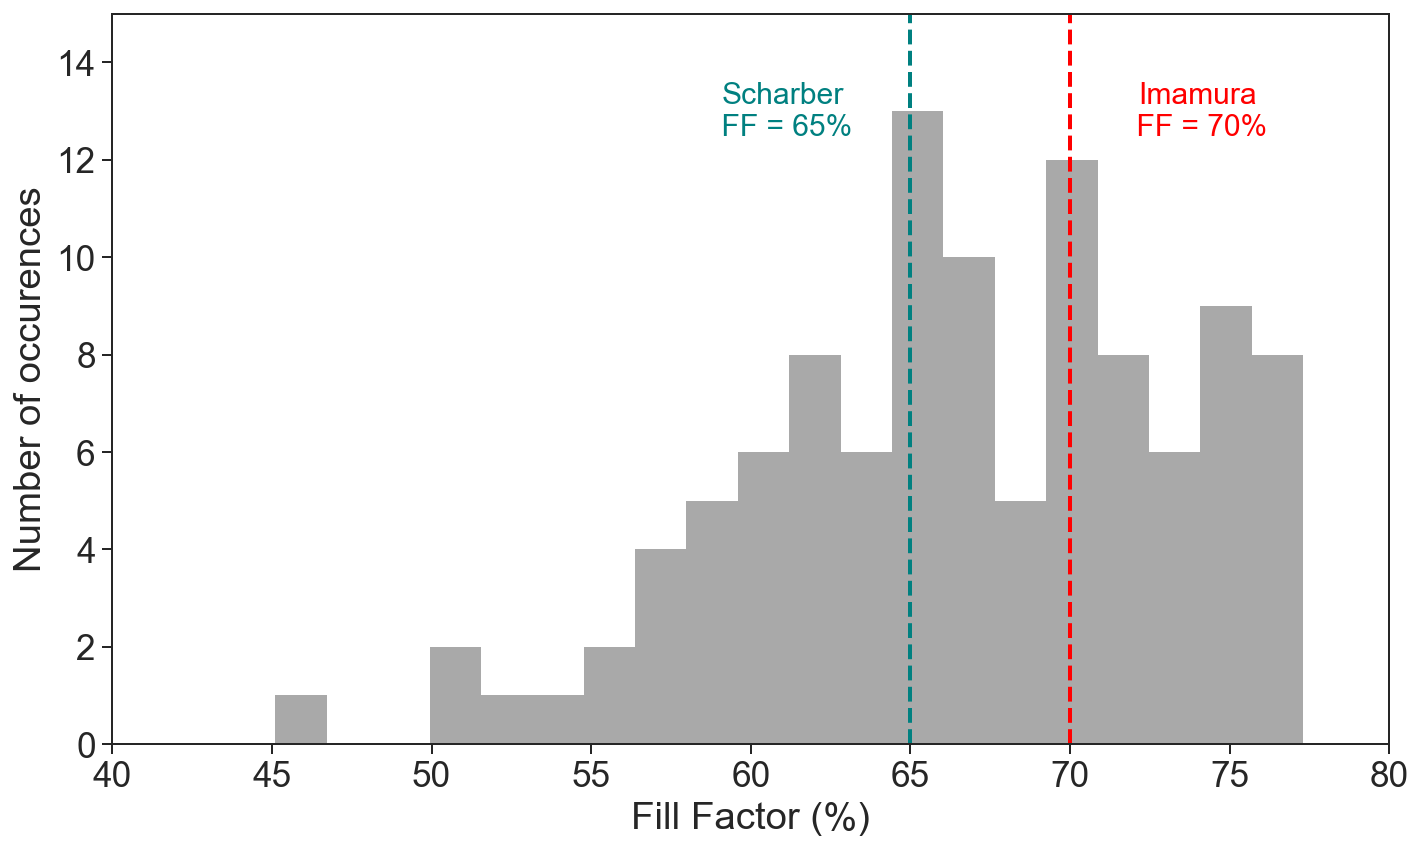

In [352]:
import scipy.stats as stats
import math

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

#plt.style.use('seaborn')
pal = sns.color_palette("hls", 8)
pal = pal.as_hex()

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

x = df_sTD.ExperimentalFF
mean = np.mean(df_sTD.ExperimentalFF)
std = np.std(df_sTD.ExperimentalFF)

fig, ax1 = plt.subplots(figsize=(10, 6))
n, bins, patches = ax1.hist(x, bins = 20, density = False, color = 'darkgray')

ax1.axvline(65, ls = '--', color = 'teal', lw = 2)
ax1.axvline(70, ls = '--', color = 'r', lw = 2)
ax1.axis([40, 80, 0, 15])

ax1.text(61, 13, "Scharber\n FF = 65%", fontsize = 15, verticalalignment = 'center', ha = 'center', color = 'teal')
ax1.text(74, 13, "Imamura\n FF = 70%", fontsize = 15, verticalalignment = 'center', ha = 'center', color = 'r')

ax1.set(xlabel = 'Fill Factor (%)', ylabel = 'Number of occurences')
plt.tight_layout()
plt.savefig('../figures/FF_histogram.pdf')
plt.show()

# Comparing cross-validated models

In [58]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)
    


def CrossValModels(predicted, target):
    # predicted is the list of predicted values. Ex: df['ScharberPCEtotal'] or PerrisPCEcalc
    # target is the target experimental value. Ex: df['ExperimentalPCE']

    X = predicted
    y = target
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'r2')
    SEM_r2 = round((score.std() / math.sqrt(5)) , 3)
    #r2 = str(round(score.mean(), 3)) + ' +/- ' +  str(SEM_r2)
    r2 = round(float(score.mean()), 3)
    
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'neg_mean_absolute_error')
    score = np.multiply(score, -1)
    SEM_MAE = round((score.std() / math.sqrt(5)) , 2)
    #MAE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_MAE)
    MAE = round(score.mean(), 2) 
    
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'neg_mean_squared_error')
    score = np.sqrt(score * -1)
    SEM_RMSE = round((score.std() / math.sqrt(5)) , 2)
    #RMSE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_RMSE)
    RMSE = round(score.mean(), 2)
    
    MAPE_scorer = make_scorer(mean_absolute_percentage_error)
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = MAPE_scorer)
    score = score * 100
    SEM_MAPE = round((score.std() / math.sqrt(5)) , 2)
    MAPE = round(score.mean(), 2)

    return round(r2,2), SEM_r2, MAE, SEM_MAE, RMSE, SEM_RMSE, MAPE, SEM_MAPE

In [59]:
# Table 1 is using only DFT data
HutchLassoCalc = []
HutchLassoFF65 = []
HutchLassoFF67 = []
HutchLassoFF70 = []
for i in range(len(LassoFF[-1])):
    HutchLassoCalc.append(LassoVoc[-1][i] * (LassoFF[-1][i]/100) * LassoJsc[-1][i])
    HutchLassoFF65.append(LassoVoc[-1][i] * 0.65 * LassoJsc[-1][i])
    HutchLassoFF67.append(LassoVoc[-1][i] * 0.67 * LassoJsc[-1][i])
    HutchLassoFF70.append(LassoVoc[-1][i] * 0.70 * LassoJsc[-1][i])
Hutchison_Lasso_PCEcalc = CrossValModels(HutchLassoCalc, df['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF65 = CrossValModels(HutchLassoFF65, df['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF67 = CrossValModels(HutchLassoFF67, df['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF70 = CrossValModels(HutchLassoFF70, df['ExperimentalPCE'])


SchPCEtot = CrossValModels(df['ScharberPCEtotal'], df['ExperimentalPCE'])
SchPCEdon = CrossValModels(df['ScharberPCEdon'], df['ExperimentalPCE'])
SchPCEacc = CrossValModels(df['ScharberPCEacc'], df['ExperimentalPCE'])
SchPCElowestoptbg = CrossValModels(df['ScharberPCElowestoptbg'], df['ExperimentalPCE'])
ImamuraPCEtot = CrossValModels(df['ImamuraPCEtotal'], df['ExperimentalPCE'])
ImamuraPCEacc = CrossValModels(df['ImamuraPCEacc'], df['ExperimentalPCE'])
ImamuraPCEdon = CrossValModels(df['ImamuraPCEdon'], df['ExperimentalPCE'])
AlharbiPCEDon = CrossValModels(df['AlharbiPCEDon'], df['ExperimentalPCE'])
AlharbiPCEAcc = CrossValModels(df['AlharbiPCEAcc'], df['ExperimentalPCE'])
Hutch_LassoPCE= LassoPCE[0:8]


list_Table1 = [SchPCEtot, SchPCEdon, SchPCEacc,SchPCElowestoptbg, ImamuraPCEtot, ImamuraPCEacc, ImamuraPCEdon, AlharbiPCEDon,AlharbiPCEAcc, Hutchison_Lasso_PCEcalc, Hutch_LassoPCE]
Table1 = pd.DataFrame(list_Table1, columns = ['r^2', '+/- r^2 SEM', 'MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['SchPCEtot', 'SchPCEdon', 'SchPCEacc', 'SchPCElowestoptbg', 'ImamuraPCEtot', 'ImamuraPCEacc', 'ImamuraPCEdon', 'AlharbiPCEDon', 'AlharbiPCEAcc', 'Hutchison_Lasso_PCEcalc', 'Hutch_LassoPCE'])
Table1.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table1)

#Table 2 is using only DFT data with experimental PCE > 9%
HutchLassoCalc_highPCE = []
HutchLassoFF65_highPCE = []
HutchLassoFF67_highPCE = []
HutchLassoFF70_highPCE = []
for i in range(len(LassoFF_highPCE[-1])):
    HutchLassoCalc_highPCE.append(LassoVoc_highPCE[-1][i] * (LassoFF_highPCE[-1][i]/100) * LassoJsc_highPCE[-1][i])
    HutchLassoFF65_highPCE.append(LassoVoc_highPCE[-1][i] * 0.65 * LassoJsc_highPCE[-1][i])
    HutchLassoFF67_highPCE.append(LassoVoc_highPCE[-1][i] * 0.67 * LassoJsc_highPCE[-1][i])
    HutchLassoFF70_highPCE.append(LassoVoc_highPCE[-1][i] * 0.70 * LassoJsc_highPCE[-1][i])
Hutchison_Lasso_PCEcalc_highPCE = CrossValModels(HutchLassoCalc_highPCE, df_highPCE['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF65_highPCE = CrossValModels(HutchLassoFF65_highPCE, df_highPCE['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF67_highPCE = CrossValModels(HutchLassoFF67_highPCE, df_highPCE['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF70_highPCE = CrossValModels(HutchLassoFF70_highPCE, df_highPCE['ExperimentalPCE'])

SchPCEtot_highPCE = CrossValModels(df_highPCE['ScharberPCEtotal'], df_highPCE['ExperimentalPCE'])
SchPCEdon_highPCE = CrossValModels(df_highPCE['ScharberPCEdon'], df_highPCE['ExperimentalPCE'])
SchPCEacc_highPCE = CrossValModels(df_highPCE['ScharberPCEacc'], df_highPCE['ExperimentalPCE'])
SchPCElowestoptbg_highPCE = CrossValModels(df_highPCE['ScharberPCElowestoptbg'], df_highPCE['ExperimentalPCE'])
ImamuraPCEtot_highPCE = CrossValModels(df_highPCE['ImamuraPCEtotal'], df_highPCE['ExperimentalPCE'])
ImamuraPCEacc_highPCE = CrossValModels(df_highPCE['ImamuraPCEacc'], df_highPCE['ExperimentalPCE'])
ImamuraPCEdon_highPCE = CrossValModels(df_highPCE['ImamuraPCEdon'], df_highPCE['ExperimentalPCE'])
AlharbiPCEDon_highPCE = CrossValModels(df_highPCE['AlharbiPCEDon'], df_highPCE['ExperimentalPCE'])
AlharbiPCEAcc_highPCE = CrossValModels(df_highPCE['AlharbiPCEAcc'], df_highPCE['ExperimentalPCE'])
Hutch_LassoPCE_highPCE = LassoPCE_highPCE[0:8]

list_Table2 = [Hutch_LassoPCE_highPCE, SchPCEtot_highPCE, SchPCEdon_highPCE, SchPCEacc_highPCE, SchPCElowestoptbg_highPCE, ImamuraPCEtot_highPCE, ImamuraPCEacc_highPCE, ImamuraPCEdon_highPCE, AlharbiPCEDon_highPCE, AlharbiPCEAcc_highPCE, Hutchison_Lasso_PCEcalc_highPCE]
Table2 = pd.DataFrame(list_Table2, columns = ['r^2', '+/- r^2 SEM','MAE','+/- MAE SEM', 'RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['Hutch_LassoPCE_highPCE', 'SchPCEtot_highPCE', 'SchPCEdon_highPCE', 'SchPCEacc_highPCE', 'SchPCElowestoptbg_highPCE', 'ImamuraPCEtot_highPCE', 'ImamuraPCEacc_highPCE', 'ImamuraPCEdon_highPCE', 'AlharbiPCEDon_highPCE', 'AlharbiPCEAcc_highPCE', 'Hutchison_Lasso_PCEcalc_highPCE'])
Table2.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table2)

#Table 3 is using only sTD-DFT data with same experimental acceptor-donor pairs as Tables 1 and 2
HutchLassoCalc_sTD = []
HutchLassoFF70_sTD = []
for i in range(len(LassoFF_sTD[-1])):
    HutchLassoCalc_sTD.append(LassoVoc_sTD[-1][i] * (LassoFF_sTD[-1][i]/100) * LassoJsc_sTD[-1][i])
    HutchLassoFF70_sTD.append(LassoVoc_sTD[-1][i] * 0.70 * LassoJsc_sTD[-1][i])
Hutchison_Lasso_PCEcalc_sTD = CrossValModels(HutchLassoCalc_sTD, df['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF70_sTD = CrossValModels(HutchLassoFF70_sTD, df['ExperimentalPCE'])

sTDDFTSchPCETot = CrossValModels(df['sTDDFTScharberPCETot'], df['ExperimentalPCE'])
sTDDFTSchPCEAcc = CrossValModels(df['sTDDFTScharberPCEAcc'], df['ExperimentalPCE'])
sTDDFTSchPCEDon = CrossValModels(df['sTDDFTScharberPCEDon'], df['ExperimentalPCE'])
Hutch_LassoPCE_sTD = LassoPCE_sTD[0:8]

list_Table3 = [sTDDFTSchPCETot, sTDDFTSchPCEAcc, sTDDFTSchPCEDon, Hutch_LassoPCE_sTD, Hutchison_Lasso_PCEcalc_sTD, Hutchison_Lasso_PCE_FF70_sTD]
Table3 = pd.DataFrame(list_Table3, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['sTDDFTSchPCETot', 'sTDDFTSchPCEAcc', 'sTDDFTSchPCEDon', 'Hutch_LassoPCE_sTD', 'Hutchison_Lasso_PCEcalc_sTD', 'Hutchison_Lasso_PCE_FF70_sTD'])
Table3.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table3)

#Table 4 is using only sTD-DFT data with same experimental acceptor-donor pairs as Tables 1 and 2, but with experimental PCE > 9%
HutchLassoCalc_sTD_highPCE = []
HutchLassoFF70_sTD_highPCE = []
for i in range(len(LassoFF_sTD_highPCE[-1])):
    HutchLassoCalc_sTD_highPCE.append(LassoVoc_sTD_highPCE[-1][i] * (LassoFF_sTD_highPCE[-1][i]/100) * LassoJsc_sTD_highPCE[-1][i])
    HutchLassoFF70_sTD_highPCE.append(LassoVoc_sTD_highPCE[-1][i] * 0.70 * LassoJsc_sTD_highPCE[-1][i])
Hutchison_Lasso_PCEcalc_sTD_highPCE = CrossValModels(HutchLassoCalc_sTD_highPCE, df_highPCE['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF70_sTD_highPCE = CrossValModels(HutchLassoFF70_sTD_highPCE, df_highPCE['ExperimentalPCE'])

sTDDFTSchPCETot_highPCE = CrossValModels(df_highPCE['sTDDFTScharberPCETot'], df_highPCE['ExperimentalPCE'])
sTDDFTSchPCEAcc_highPCE = CrossValModels(df_highPCE['sTDDFTScharberPCEAcc'], df_highPCE['ExperimentalPCE'])
sTDDFTSchPCEDon_highPCE = CrossValModels(df_highPCE['sTDDFTScharberPCEDon'], df_highPCE['ExperimentalPCE'])
Hutch_LassoPCE_sTD_highPCE = LassoPCE_sTD_highPCE[0:8]

list_Table4 = [sTDDFTSchPCETot_highPCE, sTDDFTSchPCEAcc_highPCE, sTDDFTSchPCEDon_highPCE, Hutch_LassoPCE_sTD_highPCE, Hutchison_Lasso_PCEcalc_sTD_highPCE, Hutchison_Lasso_PCE_FF70_sTD_highPCE]
Table4 = pd.DataFrame(list_Table4, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['sTDDFTSchPCETot_highPCE', 'sTDDFTSchPCEAcc_highPCE', 'sTDDFTSchPCEDon_highPCE', 'Hutch_LassoPCE_sTD_highPCE', 'Hutchison_Lasso_PCEcalc_sTD_highPCE', 'Hutchison_Lasso_PCE_FF70_sTD_highPCE'])
Table4.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table4)

#Table 5 is using only sTD-DFT data but with additional acceptor-donor pairs
HutchLassoCalc_sTD_all = []
HutchLassoFF70_sTD_all = []
for i in range(len(LassoFF_sTD_all[-1])):
    HutchLassoCalc_sTD_all.append(LassoVoc_sTD_all[-1][i] * (LassoFF_sTD_all[-1][i]/100) * LassoJsc_sTD_all[-1][i])
    HutchLassoFF70_sTD_all.append(LassoVoc_sTD_all[-1][i] * 0.70 * LassoJsc_sTD_all[-1][i])
Hutchison_Lasso_PCEcalc_sTD_all = CrossValModels(HutchLassoCalc_sTD_all, df_sTD['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF70_sTD_all = CrossValModels(HutchLassoFF70_sTD_all, df_sTD['ExperimentalPCE'])

sTDDFTSchPCETotall = CrossValModels(df_sTD['sTDDFTScharberPCETot'], df_sTD['ExperimentalPCE'])
sTDDFTSchPCEAccall = CrossValModels(df_sTD['sTDDFTScharberPCEAcc'], df_sTD['ExperimentalPCE'])
sTDDFTSchPCEDonall = CrossValModels(df_sTD['sTDDFTScharberPCEDon'], df_sTD['ExperimentalPCE'])
Hutch_LassoPCE_sTD_all = LassoPCE_sTD_all[0:8]


list_Table5 = [sTDDFTSchPCETotall, sTDDFTSchPCEAccall, sTDDFTSchPCEDonall, Hutch_LassoPCE_sTD_all, Hutchison_Lasso_PCEcalc_sTD_all, Hutchison_Lasso_PCE_FF70_sTD_all]
Table5 = pd.DataFrame(list_Table5, columns = ['r^2', '+/- r^2 SEM','MAE','+/- MAE SEM', 'RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['sTDDFTSchPCETotall', 'sTDDFTSchPCEAccall', 'sTDDFTSchPCEDonall', 'Hutch_LassoPCE_sTD_all', 'Hutchison_Lasso_PCEcalc_sTD_all', 'Hutchison_Lasso_PCE_FF70_sTD_all'])
Table5.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table5)

#Table 6 is using only sTD-DFT data but with additional acceptor-donor pairs, and PCE > 9%
HutchLassoCalc_sTD_highPCE_all = []
HutchLassoFF70_sTD_highPCE_all = []
for i in range(len(LassoFF_sTD_highPCE_all[-1])):
    HutchLassoCalc_sTD_highPCE_all.append(LassoVoc_sTD_highPCE_all[-1][i] * (LassoFF_sTD_highPCE_all[-1][i]/100) * LassoJsc_sTD_highPCE_all[-1][i])
    HutchLassoFF70_sTD_highPCE_all.append(LassoVoc_sTD_highPCE_all[-1][i] * 0.70 * LassoJsc_sTD_highPCE_all[-1][i])
Hutchison_Lasso_PCEcalc_sTD_highPCE_all = CrossValModels(HutchLassoCalc_sTD_highPCE_all, df_sTD_highPCE['ExperimentalPCE'])
Hutchison_Lasso_PCE_FF70_sTD_highPCE_all = CrossValModels(HutchLassoFF70_sTD_highPCE_all, df_sTD_highPCE['ExperimentalPCE'])

sTDDFTSchPCETotall_highPCE = CrossValModels(df_sTD_highPCE['sTDDFTScharberPCETot'], df_sTD_highPCE['ExperimentalPCE'])
sTDDFTSchPCEAccall_highPCE = CrossValModels(df_sTD_highPCE['sTDDFTScharberPCEAcc'], df_sTD_highPCE['ExperimentalPCE'])
sTDDFTSchPCEDonall_highPCE = CrossValModels(df_sTD_highPCE['sTDDFTScharberPCEDon'], df_sTD_highPCE['ExperimentalPCE'])
Hutch_LassoPCE_sTD_highPCE_all = LassoPCE_sTD_highPCE_all[0:8]

list_Table6 = [sTDDFTSchPCETotall_highPCE, sTDDFTSchPCEAccall_highPCE, sTDDFTSchPCEDonall_highPCE, Hutch_LassoPCE_sTD_highPCE_all, Hutchison_Lasso_PCEcalc_sTD_highPCE_all, Hutchison_Lasso_PCE_FF70_sTD_highPCE_all]
Table6 = pd.DataFrame(list_Table6, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['sTDDFTSchPCETotall_highPCE', 'sTDDFTSchPCEAccall_highPCE', 'sTDDFTSchPCEDonall_highPCE', 'Hutch_LassoPCE_sTD_highPCE_all', 'Hutchison_Lasso_PCEcalc_sTD_highPCE_all', 'Hutchison_Lasso_PCE_FF70_sTD_highPCE_all'])
Table6.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table6)




,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutchison_Lasso_PCEcalc,0.380,0.060,2.320,0.240,2.9400,0.27000,30.9500,5.26000
Hutch_LassoPCE,0.385,0.004,2.298,0.023,2.9967,0.01082,31.8341,0.37594
AlharbiPCEAcc,0.040,0.068,3.150,0.270,3.6900,0.31000,46.3000,8.72000
AlharbiPCEDon,-0.040,0.017,3.250,0.250,3.8100,0.23000,47.1300,7.63000
SchPCEdon,-0.050,0.028,3.240,0.240,3.8400,0.22000,47.6000,7.68000
ImamuraPCEdon,-0.050,0.028,3.240,0.240,3.8400,0.22000,47.6000,7.68000
SchPCElowestoptbg,-0.160,0.125,3.380,0.240,3.9900,0.23000,49.7800,7.61000
SchPCEtot,-0.150,0.093,3.380,0.240,4.0000,0.22000,49.3700,7.54000
ImamuraPCEtot,-0.150,0.093,3.380,0.240,4.0000,0.22000,49.3700,7.54000
SchPCEacc,-0.170,0.084,3.390,0.250,4.0300,0.23000,49.9000,7.78000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoPCE_highPCE,0.606,0.009,1.353,0.018,1.608,0.01755,11.1087,0.20533
Hutchison_Lasso_PCEcalc_highPCE,0.410,0.066,1.490,0.110,1.790,0.10000,12.3500,1.12000
AlharbiPCEDon_highPCE,-0.100,0.268,2.000,0.230,2.340,0.22000,16.6900,1.97000
SchPCEdon_highPCE,-0.170,0.236,2.100,0.250,2.450,0.20000,17.7000,1.97000
ImamuraPCEdon_highPCE,-0.170,0.236,2.100,0.250,2.450,0.20000,17.7000,1.97000
AlharbiPCEAcc_highPCE,-0.210,0.155,2.310,0.240,2.570,0.20000,19.3600,1.92000
SchPCEtot_highPCE,-0.310,0.225,2.320,0.220,2.630,0.18000,19.6400,1.80000
ImamuraPCEtot_highPCE,-0.310,0.225,2.320,0.220,2.630,0.18000,19.6400,1.80000
SchPCElowestoptbg_highPCE,-0.320,0.152,2.410,0.190,2.670,0.14000,20.2500,1.44000
SchPCEacc_highPCE,-0.340,0.142,2.440,0.180,2.710,0.14000,20.4600,1.40000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutchison_Lasso_PCEcalc_sTD,0.470,0.065,2.230,0.210,2.7100,0.25000,30.9800,4.58000
Hutchison_Lasso_PCE_FF70_sTD,0.460,0.073,2.220,0.260,2.7400,0.30000,30.9500,5.54000
Hutch_LassoPCE_sTD,0.469,0.004,2.211,0.018,2.7848,0.00968,29.8179,0.22331
sTDDFTSchPCEDon,0.130,0.066,3.050,0.260,3.5000,0.30000,40.3400,6.13000
sTDDFTSchPCETot,0.030,0.058,3.190,0.280,3.7000,0.31000,44.6700,7.65000
sTDDFTSchPCEAcc,-0.030,0.037,3.260,0.270,3.8200,0.27000,47.3000,8.10000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutchison_Lasso_PCEcalc_sTD_highPCE,0.320,0.179,1.540,0.16,1.7800,0.20000,12.6100,1.28000
Hutch_LassoPCE_sTD_highPCE,0.514,0.004,1.466,0.02,1.7858,0.00747,12.3491,0.13907
Hutchison_Lasso_PCE_FF70_sTD_highPCE,0.170,0.196,1.670,0.19,1.9900,0.21000,13.7600,1.57000
sTDDFTSchPCEDon_highPCE,-0.280,0.140,2.370,0.22,2.6500,0.17000,19.9000,1.58000
sTDDFTSchPCETot_highPCE,-0.330,0.118,2.410,0.20,2.7000,0.15000,20.1500,1.41000
sTDDFTSchPCEAcc_highPCE,-0.380,0.127,2.470,0.20,2.7600,0.17000,20.6000,1.37000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoPCE_sTD_all,0.44,0.003,2.058,0.02,2.6742,0.00765,28.0563,0.29187
Hutchison_Lasso_PCEcalc_sTD_all,0.34,0.094,2.200,0.22,2.7000,0.26000,29.3300,5.21000
Hutchison_Lasso_PCE_FF70_sTD_all,0.32,0.096,2.230,0.23,2.7500,0.26000,29.4300,5.29000
sTDDFTSchPCEDonall,-0.12,0.043,3.000,0.17,3.5600,0.15000,40.2000,6.24000
sTDDFTSchPCETotall,-0.18,0.077,3.040,0.15,3.6300,0.14000,41.7100,6.65000
sTDDFTSchPCEAccall,-0.22,0.077,3.060,0.16,3.7000,0.15000,42.9800,7.16000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoPCE_sTD_highPCE_all,0.502,0.006,1.382,0.011,1.6881,0.00973,11.544,0.08719
Hutchison_Lasso_PCEcalc_sTD_highPCE_all,0.150,0.124,1.500,0.190,1.7900,0.18000,12.560,1.39000
Hutchison_Lasso_PCE_FF70_sTD_highPCE_all,-0.030,0.147,1.640,0.230,2.0000,0.22000,13.830,1.74000
sTDDFTSchPCEDonall_highPCE,-0.710,0.441,2.220,0.250,2.4700,0.23000,18.530,1.87000
sTDDFTSchPCETotall_highPCE,-0.750,0.439,2.250,0.250,2.5000,0.22000,18.690,1.90000
sTDDFTSchPCEAccall_highPCE,-0.750,0.443,2.250,0.250,2.5000,0.22000,18.690,1.90000


# Comparing models for FF, Jsc, and Voc

In [60]:
#Table 7 is comparing all models for Fill Factor (FF) with high PCE
ScharberFF_highPCE = CrossValModels(df_highPCE['ScharberFF'], df_highPCE['ExperimentalFF'])
AlharbiFFDon_highPCE = CrossValModels(df_highPCE['AlharbiFFDon'], df_highPCE['ExperimentalFF'])
AlharbiFFAcc_highPCE = CrossValModels(df_highPCE['AlharbiFFAcc'], df_highPCE['ExperimentalFF'])
ImamuraFF_highPCE = CrossValModels(df_highPCE['ImamuraFF'], df_highPCE['ExperimentalFF'])
Hutch_LassoFF_highPCE = LassoFF_highPCE[0:8]
Hutch_LassoFF_sTD_highPCE = LassoFF_sTD_highPCE[0:8]
Hutch_LassoFF_sTD_highPCE_all = LassoFF_sTD_highPCE_all[0:8]

list_Table7 = [ScharberFF_highPCE, AlharbiFFDon_highPCE, AlharbiFFAcc_highPCE, ImamuraFF_highPCE, Hutch_LassoFF_highPCE, Hutch_LassoFF_sTD_highPCE, Hutch_LassoFF_sTD_highPCE_all]
Table7 = pd.DataFrame(list_Table7, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['ScharberFF_highPCE', 'AlharbiFFDon_highPCE', 'AlharbiFFAcc_highPCE', 'ImamuraFF_highPCE', 'Hutch_LassoFF_highPCE', 'Hutch_LassoFF_sTD_highPCE', 'Hutch_LassoFF_sTD_highPCE_all'])
Table7.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table7)

#Table 7b is comparing all models for Fill Factor (FF) 
ScharberFF = CrossValModels(df['ScharberFF'], df['ExperimentalFF'])
AlharbiFFDon = CrossValModels(df['AlharbiFFDon'], df['ExperimentalFF'])
AlharbiFFAcc = CrossValModels(df['AlharbiFFAcc'], df['ExperimentalFF'])
ImamuraFF = CrossValModels(df['ImamuraFF'], df['ExperimentalFF'])
Hutch_LassoFF = LassoFF[0:8]
Hutch_LassoFF_sTD = LassoFF_sTD[0:8]
Hutch_LassoFF_sTD_all = LassoFF_sTD_all[0:8]

list_Table7b = [ScharberFF, AlharbiFFDon, AlharbiFFAcc, ImamuraFF, Hutch_LassoFF, Hutch_LassoFF_sTD, Hutch_LassoFF_sTD_all]
Table7b = pd.DataFrame(list_Table7b, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['ScharberFF', 'AlharbiFFDon', 'AlharbiFFAcc', 'ImamuraFF', 'Hutch_LassoFF', 'Hutch_LassoFF_sTD', 'Hutch_LassoFF_sTD_all'])
Table7b.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table7b)


#Table 8 is comparing all models for short circuit current (Jsc) for high PCE
ScharberJscAcc_highPCE = CrossValModels(df_highPCE['ScharberJscAcc'], df_highPCE['ExperimentalJsc'])
ImamuraTotalJsc_highPCE = CrossValModels(df_highPCE['ImamuraTotalJsc'], df_highPCE['ExperimentalJsc'])
ImamuraJscAcc_highPCE = CrossValModels(df_highPCE['ImamuraJscAcc'], df_highPCE['ExperimentalJsc'])
ImamuraJscDon_highPCE = CrossValModels(df_highPCE['ImamuraJscDon'], df_highPCE['ExperimentalJsc'])
ScharberTotalJsc_highPCE = CrossValModels(df_highPCE['ScharberTotalJsc'], df_highPCE['ExperimentalJsc'])
ScharberJscDon_highPCE = CrossValModels(df_highPCE['ScharberJscDon'], df_highPCE['ExperimentalJsc'])
ScharberJsclowestoptbg_highPCE = CrossValModels(df_highPCE['ScharberJsclowestoptbg'], df_highPCE['ExperimentalJsc'])
Hutch_LassoJsc_highPCE = LassoJsc_highPCE[0:8]
Hutch_LassoJsc_sTD_highPCE = LassoJsc_sTD_highPCE[0:8]
Hutch_LassoJsc_sTD_highPCE_all = LassoJsc_sTD_highPCE_all[0:8]

list_Table8 = [ScharberJscAcc_highPCE, ImamuraTotalJsc_highPCE, ImamuraJscAcc_highPCE, ImamuraJscDon_highPCE, ScharberTotalJsc_highPCE, ScharberJscDon_highPCE, ScharberJsclowestoptbg_highPCE, Hutch_LassoJsc_highPCE, Hutch_LassoJsc_sTD_highPCE, Hutch_LassoJsc_sTD_highPCE_all]
Table8 = pd.DataFrame(list_Table8, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['ScharberJscAcc_highPCE', 'ImamuraTotalJsc_highPCE', 'ImamuraJscAcc_highPCE', 'ImamuraJscDon_highPCE', 'ScharberTotalJsc_highPCE', 'ScharberJscDon_highPCE', 'ScharberJsclowestoptbg_highPCE', 'Hutch_LassoJsc_highPCE', 'Hutch_LassoJsc_sTD_highPCE', 'Hutch_LassoJsc_sTD_highPCE_all'])
Table8.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table8)

#Table 8b is comparing all models for short circuit current (Jsc)
ScharberJscAcc = CrossValModels(df['ScharberJscAcc'], df['ExperimentalJsc'])
ImamuraTotalJsc = CrossValModels(df['ImamuraTotalJsc'], df['ExperimentalJsc'])
ImamuraJscAcc = CrossValModels(df['ImamuraJscAcc'], df['ExperimentalJsc'])
ImamuraJscDon = CrossValModels(df['ImamuraJscDon'], df['ExperimentalJsc'])
ScharberTotalJsc = CrossValModels(df['ScharberTotalJsc'], df['ExperimentalJsc'])
ScharberJscDon = CrossValModels(df['ScharberJscDon'], df['ExperimentalJsc'])
ScharberJsclowestoptbg = CrossValModels(df['ScharberJsclowestoptbg'], df['ExperimentalJsc'])
Hutch_LassoJsc = LassoJsc[0:8]
Hutch_LassoJsc_sTD = LassoJsc_sTD[0:8]
Hutch_LassoJsc_sTD_all = LassoJsc_sTD_all[0:8]


list_Table8b = [ScharberJscAcc, ImamuraTotalJsc, ImamuraJscAcc, ImamuraJscDon, ScharberTotalJsc, ScharberJscDon, ScharberJsclowestoptbg, Hutch_LassoJsc, Hutch_LassoJsc_sTD, Hutch_LassoJsc_sTD_all]
Table8b = pd.DataFrame(list_Table8b, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['ScharberJscAcc', 'ImamuraTotalJsc', 'ImamuraJscAcc', 'ImamuraJscDon', 'ScharberTotalJsc', 'ScharberJscDon', 'ScharberJsclowestoptbg','Hutch_LassoJsc', 'Hutch_LassoJsc_sTD', 'Hutch_LassoJsc_sTD_all'])
Table8b.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table8b)

#Table 9 is comparing all models for open circuit voltage (Voc) for high PCE
AlharbiVocAcc_highPCE = CrossValModels(df_highPCE['AlharbiVocAcc'], df_highPCE['ExperimentalVoc'])
AlharbiVocDon_highPCE = CrossValModels(df_highPCE['AlharbiVocDon'], df_highPCE['ExperimentalVoc'])
ImamuraVoc_highPCE = CrossValModels(df_highPCE['ImamuraVoc'], df_highPCE['ExperimentalVoc'])
ScharberVoc_highPCE = CrossValModels(df_highPCE['ScharberVoc'], df_highPCE['ExperimentalVoc'])
Hutch_LassoVoc_highPCE = LassoVoc_highPCE[0:8]
Hutch_LassoVoc_sTD_highPCE = LassoVoc_sTD_highPCE[0:8]
Hutch_LassoVoc_sTD_highPCE_all = LassoVoc_sTD_highPCE_all[0:8]

list_Table9 = [AlharbiVocAcc_highPCE, AlharbiVocDon_highPCE, ImamuraVoc_highPCE,  ScharberVoc_highPCE, Hutch_LassoVoc_highPCE, Hutch_LassoVoc_sTD_highPCE, Hutch_LassoVoc_sTD_highPCE_all]
Table9 = pd.DataFrame(list_Table9, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['AlharbiVocAcc_highPCE', 'AlharbiVocDon_highPCE', 'ImamuraVoc_highPCE', 'ScharberVoc_highPCE', 'Hutch_LassoVoc_highPCE', 'Hutch_LassoVoc_sTD_highPCE', 'Hutch_LassoVoc_sTD_highPCE_all'])
Table9.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table9)

#Table 9b is comparing all models for open circuit voltage (Voc)
AlharbiVocAcc = CrossValModels(df['AlharbiVocAcc'], df['ExperimentalVoc'])
AlharbiVocDon = CrossValModels(df['AlharbiVocDon'], df['ExperimentalVoc'])
ImamuraVoc = CrossValModels(df['ImamuraVoc'], df['ExperimentalVoc'])
ScharberVoc = CrossValModels(df['ScharberVoc'], df['ExperimentalVoc'])
Hutch_LassoVoc = LassoVoc[0:8]
Hutch_LassoVoc_sTD = LassoVoc_sTD[0:8]
Hutch_LassoVoc_sTD_all = LassoVoc_sTD_all[0:8]

list_Table9b = [AlharbiVocAcc, AlharbiVocDon, ImamuraVoc,  ScharberVoc, Hutch_LassoVoc, Hutch_LassoVoc_sTD, Hutch_LassoVoc_sTD_all]
Table9b = pd.DataFrame(list_Table9b, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['AlharbiVocAcc', 'AlharbiVocDon', 'ImamuraVoc', 'ScharberVoc', 'Hutch_LassoVoc', 'Hutch_LassoVoc_sTD', 'Hutch_LassoVoc_sTD_all'])
Table9b.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table9b)



,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoFF_sTD_highPCE,0.451,0.006,3.032,0.029,4.0269,0.02087,4.5419,0.03436
Hutch_LassoFF_sTD_highPCE_all,0.383,0.002,3.362,0.022,4.2047,0.00691,5.0323,0.02295
Hutch_LassoFF_highPCE,0.398,0.002,3.157,0.029,4.2165,0.00582,4.7421,0.04067
AlharbiFFDon_highPCE,0.080,0.084,4.000,0.250,4.9300,0.29000,5.9900,0.41000
AlharbiFFAcc_highPCE,-0.050,0.039,4.370,0.330,5.3200,0.33000,6.4800,0.52000
ScharberFF_highPCE,-0.110,0.059,4.520,0.270,5.4600,0.32000,6.7200,0.44000
ImamuraFF_highPCE,-0.110,0.059,4.520,0.270,5.4600,0.32000,6.7200,0.44000


0.02087
0.00691


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoFF_sTD,0.268,0.006,4.548,0.020,5.8955,0.02588,7.1870,0.02423
Hutch_LassoFF_sTD_all,0.198,0.003,4.608,0.014,5.9302,0.01255,7.2825,0.02145
Hutch_LassoFF,0.175,0.003,4.930,0.035,6.2571,0.01261,7.7952,0.03802
AlharbiFFDon,-0.010,0.024,5.530,0.560,6.7200,0.64000,8.7000,0.99000
ScharberFF,-0.030,0.011,5.600,0.550,6.7800,0.62000,8.7800,0.99000
AlharbiFFAcc,-0.030,0.011,5.620,0.560,6.7800,0.62000,8.8100,1.00000
ImamuraFF,-0.030,0.011,5.600,0.550,6.7800,0.62000,8.7800,0.99000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoJsc_sTD_highPCE_all,0.607,0.006,1.716,0.019,2.1388,0.01583,8.5004,0.07729
Hutch_LassoJsc_sTD_highPCE,0.621,0.006,1.760,0.014,2.1581,0.01669,8.5718,0.10884
Hutch_LassoJsc_highPCE,0.545,0.005,1.860,0.016,2.3630,0.01404,9.1347,0.12875
ScharberJscAcc_highPCE,-0.860,0.575,3.080,0.140,3.7600,0.08000,15.6800,0.78000
ImamuraJscAcc_highPCE,-0.860,0.575,3.080,0.140,3.7600,0.08000,15.6800,0.78000
ImamuraJscDon_highPCE,-1.020,0.735,3.170,0.190,3.7800,0.24000,16.1400,1.30000
ScharberJscDon_highPCE,-1.020,0.735,3.170,0.190,3.7800,0.24000,16.1400,1.30000
ScharberJsclowestoptbg_highPCE,-0.930,0.587,3.130,0.160,3.8300,0.16000,16.0600,1.06000
ImamuraTotalJsc_highPCE,-0.970,0.555,3.210,0.200,3.9000,0.24000,16.4900,1.45000
ScharberTotalJsc_highPCE,-0.970,0.555,3.210,0.200,3.9000,0.24000,16.4900,1.45000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoJsc_sTD_all,0.555,0.005,2.631,0.012,3.5128,0.01971,19.2043,0.17719
Hutch_LassoJsc_sTD,0.571,0.004,2.727,0.025,3.6818,0.01833,20.7857,0.12337
Hutch_LassoJsc,0.501,0.002,2.888,0.011,3.9734,0.00920,21.4557,0.08184
ImamuraTotalJsc,0.030,0.070,4.630,0.390,5.4200,0.48000,33.9400,4.79000
ScharberTotalJsc,0.030,0.070,4.640,0.390,5.4200,0.48000,33.9400,4.79000
ScharberJscAcc,0.030,0.080,4.560,0.410,5.4300,0.52000,34.1500,5.16000
ImamuraJscAcc,0.030,0.080,4.560,0.410,5.4300,0.52000,34.1400,5.16000
ImamuraJscDon,-0.040,0.028,4.780,0.300,5.6000,0.35000,34.9900,3.94000
ScharberJscDon,-0.040,0.028,4.780,0.300,5.6000,0.35000,34.9900,3.94000
ScharberJsclowestoptbg,-0.050,0.033,4.800,0.340,5.6500,0.40000,35.7500,4.46000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoVoc_sTD_highPCE,0.482,0.038,0.048,0.002,0.0664,0.00236,5.7984,0.18857
Hutch_LassoVoc_highPCE,0.455,0.023,0.051,0.001,0.0682,0.00145,6.0913,0.07408
Hutch_LassoVoc_sTD_highPCE_all,0.401,0.046,0.052,0.002,0.0684,0.00257,6.1929,0.21813
ImamuraVoc_highPCE,-0.050,0.056,0.070,0.010,0.0800,0.01000,8.2900,0.88000
ScharberVoc_highPCE,-0.050,0.056,0.070,0.010,0.0800,0.01000,8.2900,0.88000
AlharbiVocAcc_highPCE,-0.110,0.074,0.070,0.010,0.0900,0.01000,8.1200,1.04000
AlharbiVocDon_highPCE,-0.150,0.088,0.070,0.010,0.0900,0.01000,8.3900,0.94000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoVoc_sTD,0.562,0.015,0.056,0.001,0.0741,0.00126,6.8194,0.10892
Hutch_LassoVoc_sTD_all,0.390,0.024,0.064,0.001,0.0822,0.00159,7.7581,0.16951
Hutch_LassoVoc,0.323,0.005,0.072,0.000,0.0922,0.00035,8.9151,0.04020
ImamuraVoc,0.090,0.039,0.080,0.010,0.1000,0.01000,10.0500,1.10000
ScharberVoc,0.090,0.039,0.080,0.010,0.1000,0.01000,10.0500,1.10000
AlharbiVocDon,-0.070,0.031,0.090,0.010,0.1100,0.01000,10.7300,0.90000
AlharbiVocAcc,-0.600,0.447,0.090,0.010,0.1300,0.02000,11.9600,1.70000


In [61]:
def make_barplots(param, ax, stat=None):    
    if param == 'FF':
        MAE = [ScharberFF_highPCE[2], ImamuraFF_highPCE[2], AlharbiFFDon_highPCE[2], Hutch_LassoFF_highPCE[2], Hutch_LassoFF_sTD_highPCE[2] ]
        SEM_MAE =[ScharberFF_highPCE[3], ImamuraFF_highPCE[3], AlharbiFFDon_highPCE[3], Hutch_LassoFF_highPCE[3], Hutch_LassoFF_sTD_highPCE[3] ]
        RMSE = [ScharberFF_highPCE[4], ImamuraFF_highPCE[4], AlharbiFFDon_highPCE[4], Hutch_LassoFF_highPCE[4], Hutch_LassoFF_sTD_highPCE[4] ]
        SEM_RMSE=[ScharberFF_highPCE[5], ImamuraFF_highPCE[5], AlharbiFFDon_highPCE[5], Hutch_LassoFF_highPCE[5], Hutch_LassoFF_sTD_highPCE[5] ]
        MAPE = [ScharberFF_highPCE[6], ImamuraFF_highPCE[6], AlharbiFFDon_highPCE[6], Hutch_LassoFF_highPCE[6], Hutch_LassoFF_sTD_highPCE[6]]
        SEM_MAPE =  [ScharberFF_highPCE[7], ImamuraFF_highPCE[7], AlharbiFFDon_highPCE[7], Hutch_LassoFF_highPCE[7], Hutch_LassoFF_sTD_highPCE[7]]
        labels = ['Scharber', 'Imamura', 'Alharbi', 'OPEP / B3LYP', 'OPEP / sTD-DFT']
        x = np.arange(5)
        
    elif param == 'Voc':
        MAE = [ScharberVoc_highPCE[2], ImamuraVoc_highPCE[2], AlharbiVocDon_highPCE[2], Hutch_LassoVoc_highPCE[2], Hutch_LassoVoc_sTD_highPCE[2] ]
        SEM_MAE = [ScharberVoc_highPCE[3], ImamuraVoc_highPCE[3], AlharbiVocDon_highPCE[3], Hutch_LassoVoc_highPCE[3], Hutch_LassoVoc_sTD_highPCE[3]]
        RMSE = [ScharberVoc_highPCE[4], ImamuraVoc_highPCE[4], AlharbiVocDon_highPCE[4], Hutch_LassoVoc_highPCE[4], Hutch_LassoVoc_sTD_highPCE[4]]
        SEM_RMSE=[ScharberVoc_highPCE[5], ImamuraVoc_highPCE[5], AlharbiVocDon_highPCE[5], Hutch_LassoVoc_highPCE[5], Hutch_LassoVoc_sTD_highPCE[5]]
        MAPE = [ScharberVoc_highPCE[6], ImamuraVoc_highPCE[6], AlharbiVocDon_highPCE[6], Hutch_LassoVoc_highPCE[6], Hutch_LassoVoc_sTD_highPCE[6]]
        SEM_MAPE =  [ScharberVoc_highPCE[7], ImamuraVoc_highPCE[7], AlharbiVocDon_highPCE[7], Hutch_LassoVoc_highPCE[7], Hutch_LassoVoc_sTD_highPCE[7]]
        labels = ['Scharber', 'Imamura', 'Alharbi', 'OPEP / B3LYP', 'OPEP / sTD-DFT']
        x = np.arange(5)
    
    elif param == 'Jsc':
        MAE = [ScharberJscDon_highPCE[2], ImamuraJscDon_highPCE[2], Hutch_LassoJsc_highPCE[2], Hutch_LassoJsc_sTD_highPCE[2] ]
        SEM_MAE = [ScharberJscDon_highPCE[3], ImamuraJscDon_highPCE[3],  Hutch_LassoJsc_highPCE[3], Hutch_LassoJsc_sTD_highPCE[3]]
        RMSE = [ScharberJscDon_highPCE[4], ImamuraJscDon_highPCE[4],  Hutch_LassoJsc_highPCE[4], Hutch_LassoJsc_sTD_highPCE[4]]
        SEM_RMSE=[ScharberJscDon_highPCE[5], ImamuraJscDon_highPCE[5],  Hutch_LassoJsc_highPCE[5], Hutch_LassoJsc_sTD_highPCE[5]]
        MAPE = [ScharberJscDon_highPCE[6], ImamuraJscDon_highPCE[6], Hutch_LassoJsc_highPCE[6], Hutch_LassoJsc_sTD_highPCE[6]]
        SEM_MAPE =  [ScharberJscDon_highPCE[7], ImamuraJscDon_highPCE[7], Hutch_LassoJsc_highPCE[7], Hutch_LassoJsc_sTD_highPCE[7]]
        labels = ['Scharber', 'Imamura', 'OPEP / B3LYP', 'OPEP / sTD-DFT']
        x = np.arange(4)
        
    elif param == 'PCE':
        MAE = [SchPCEdon_highPCE[2], ImamuraPCEdon_highPCE[2], AlharbiPCEDon_highPCE[2],Hutch_LassoPCE_highPCE[2], Hutch_LassoPCE_sTD_highPCE[2] ]
        SEM_MAE = [SchPCEdon_highPCE[3], ImamuraPCEdon_highPCE[3], AlharbiPCEDon_highPCE[3], Hutch_LassoPCE_highPCE[3], Hutch_LassoPCE_sTD_highPCE[3]]
        RMSE = [SchPCEdon_highPCE[4], ImamuraPCEdon_highPCE[4], AlharbiPCEDon_highPCE[4], Hutch_LassoPCE_highPCE[4], Hutch_LassoPCE_sTD_highPCE[4]]
        SEM_RMSE=[SchPCEdon_highPCE[5], ImamuraPCEdon_highPCE[5], AlharbiPCEDon_highPCE[5], Hutch_LassoPCE_highPCE[5], Hutch_LassoPCE_sTD_highPCE[5]]
        MAPE = [SchPCEdon_highPCE[6], ImamuraPCEdon_highPCE[6], AlharbiPCEDon_highPCE[6],Hutch_LassoPCE_highPCE[6], Hutch_LassoPCE_sTD_highPCE[6]]
        SEM_MAPE =  [SchPCEdon_highPCE[7], ImamuraPCEdon_highPCE[7], AlharbiPCEDon_highPCE[7],Hutch_LassoPCE_highPCE[7], Hutch_LassoPCE_sTD_highPCE[7]]
        labels = ['Scharber', 'Imamura', 'Alharbi','OPEP / B3LYP', 'OPEP / sTD-DFT']
        x = np.arange(5)
        
    else:
        return "not a valid param"
    
    width = 0.3
    if stat =='MAPE':
        ax.bar(x, MAPE, width, yerr=SEM_MAPE, label = "MAPE", color = 'firebrick')
        ax.legend(['MAPE'], loc = 'upper right')

        
    else:
        ax.bar(x-width/2, MAE, width, yerr=SEM_MAE, label = "MAE", color = '#007f92')
        ax.bar(x+width/2, RMSE, width, yerr=SEM_RMSE, label = "RMSE", color = '#a1196b')
        ax.legend(['MAE', 'RMSE'], loc = 'upper right')


    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation = 45, ha = 'right')
    ax.set_title(param, weight = 'bold')
    


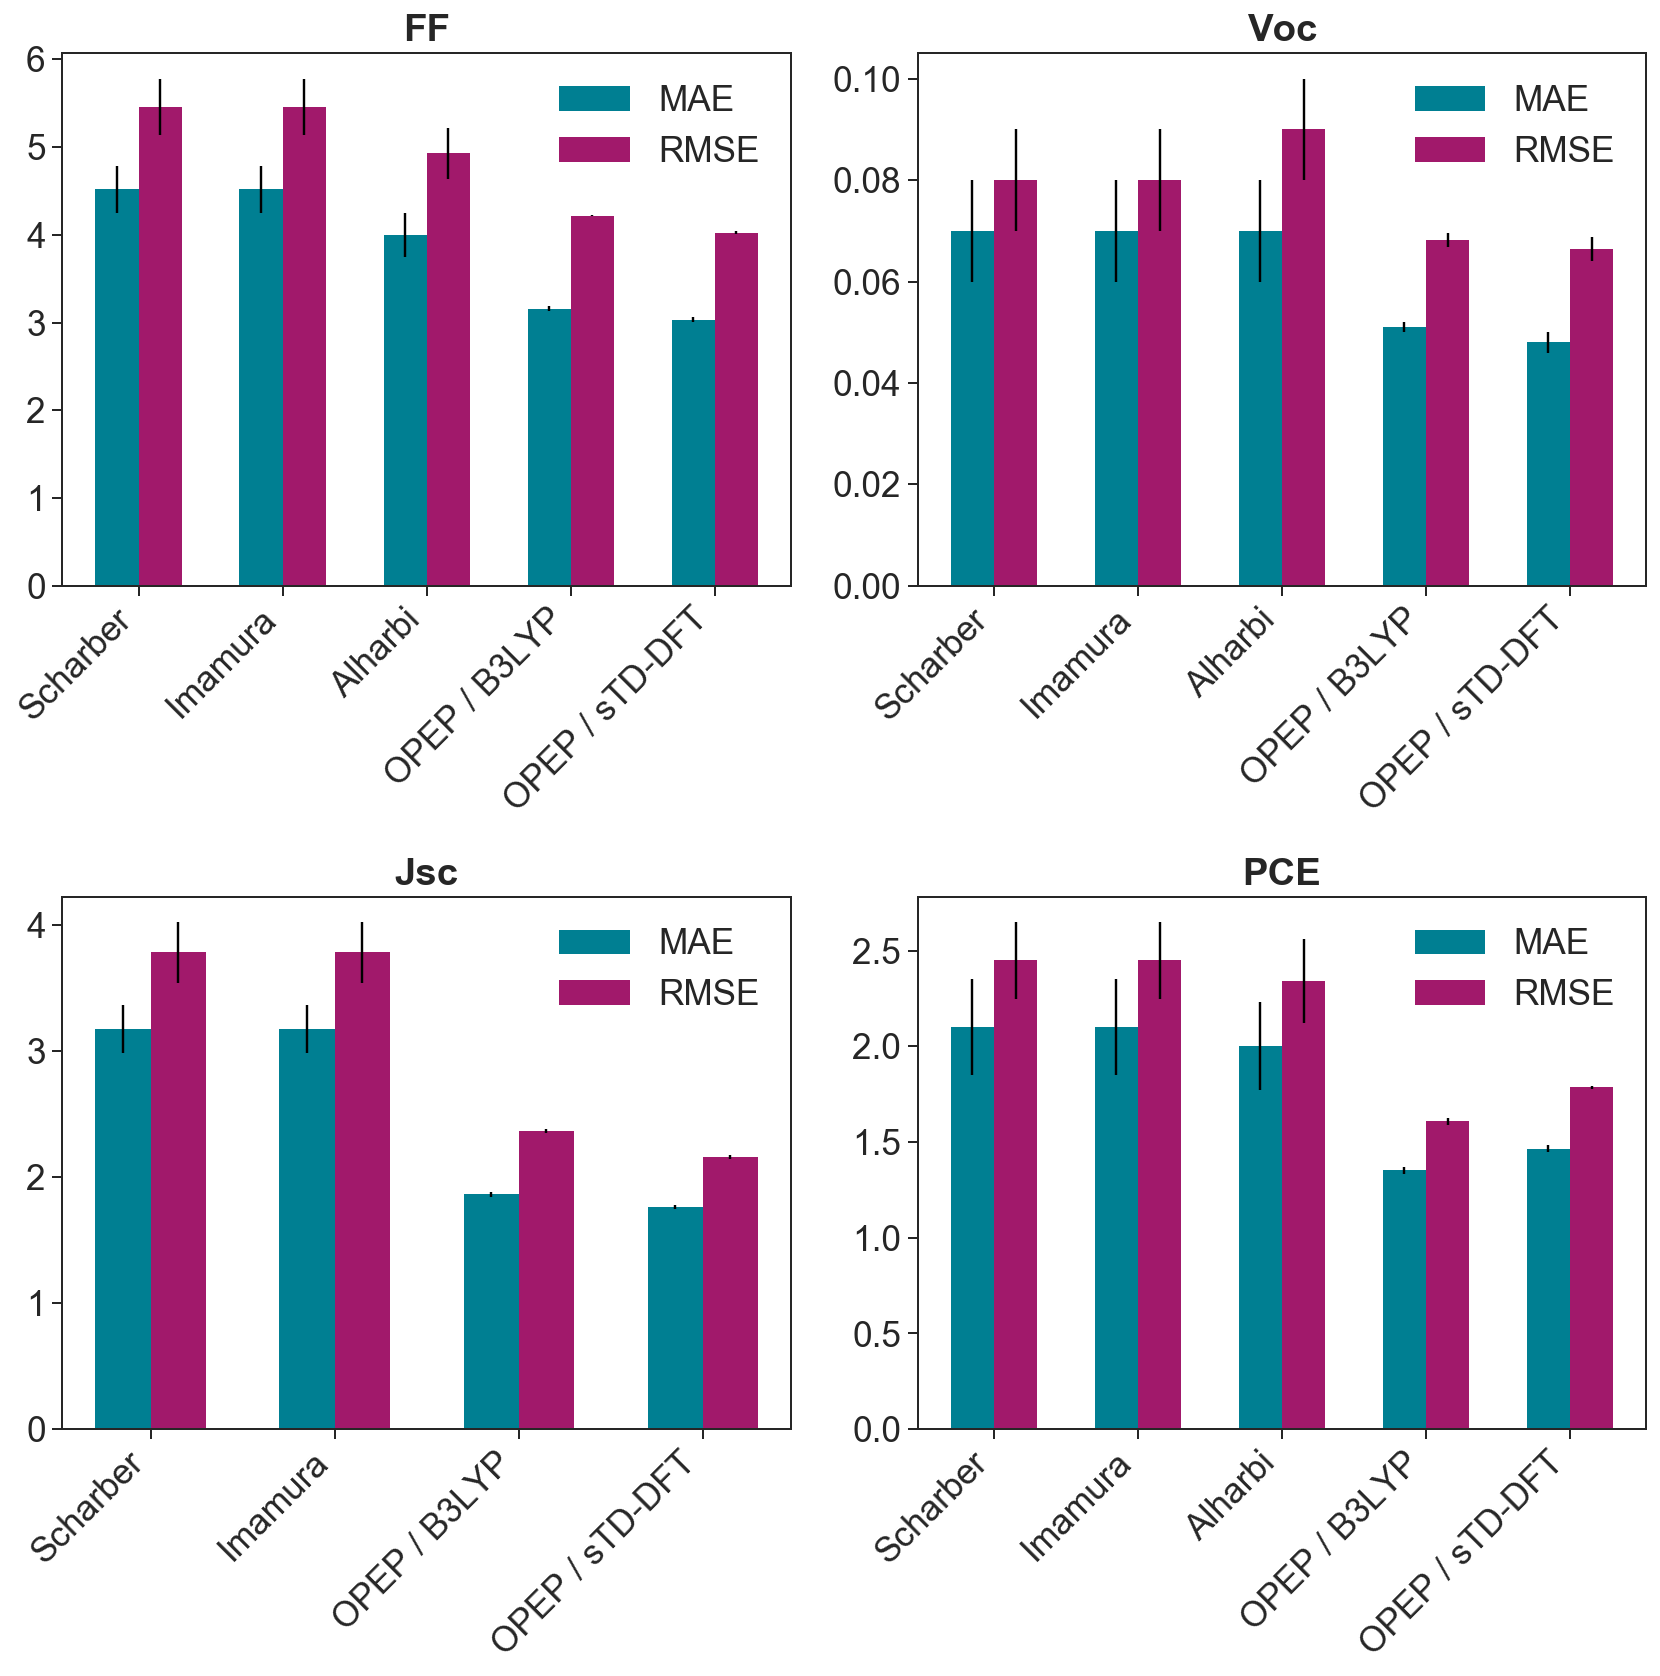

In [62]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12, 12))

make_barplots("FF", ax1)
make_barplots("Voc", ax2)
make_barplots("Jsc", ax3)
make_barplots("PCE", ax4)

plt.subplots_adjust(top = 0.93, wspace = 0.3, hspace = 0.4)
plt.tight_layout()
plt.savefig('../figures/barplots_highPCE.png', dpi = 300)
plt.savefig('../figures/barplots_highPCE.svg', dpi=300)
plt.show()

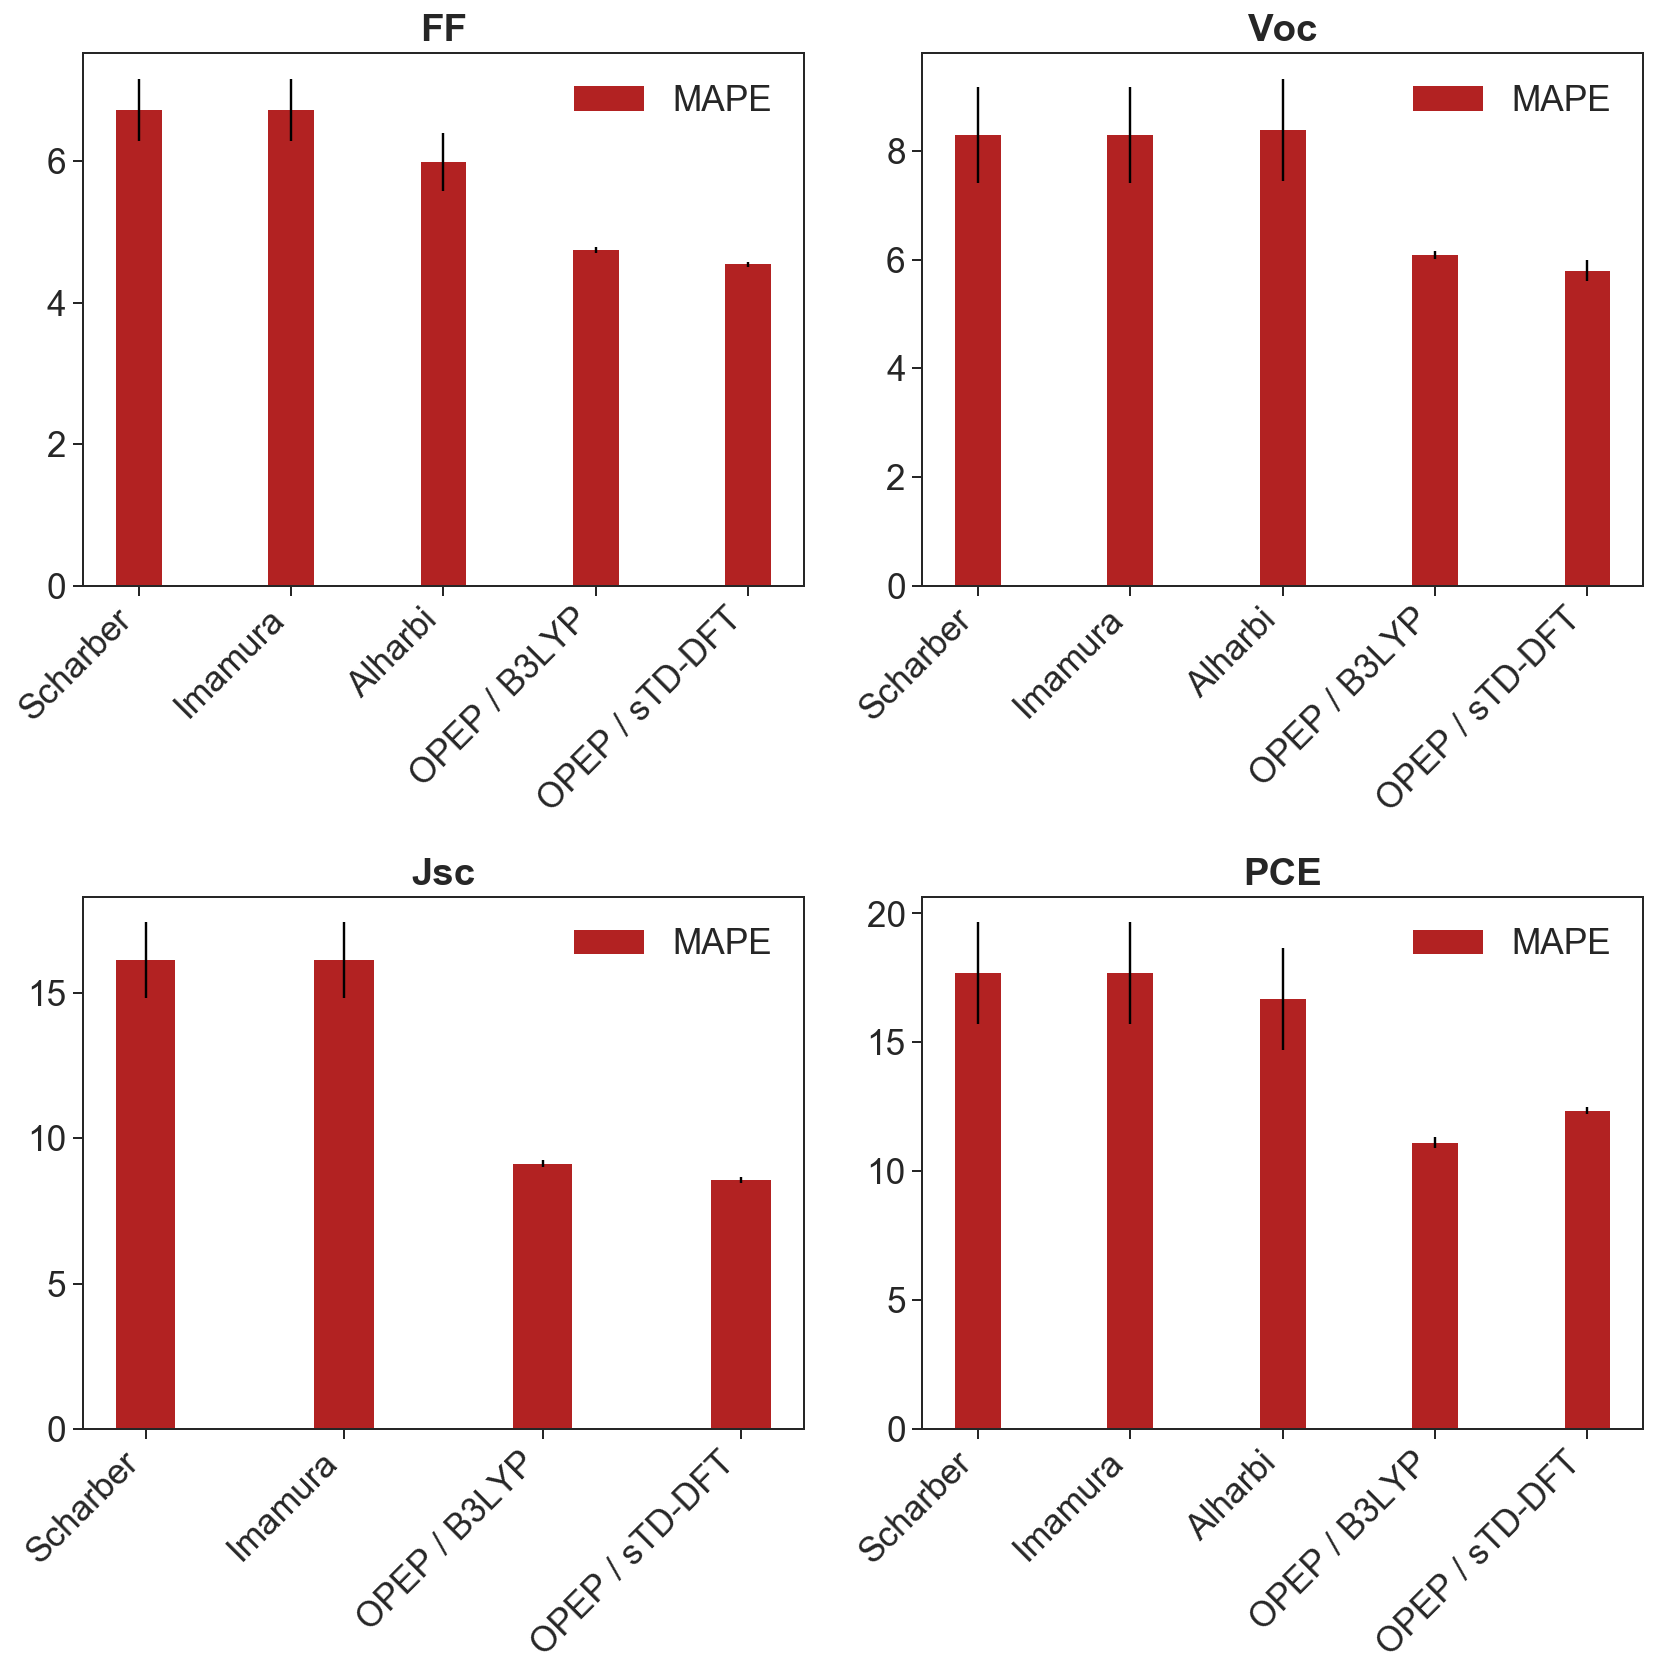

In [63]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12, 12))

make_barplots("FF", ax1, stat = 'MAPE')
make_barplots("Voc", ax2, stat = 'MAPE')
make_barplots("Jsc", ax3, stat = 'MAPE')
make_barplots("PCE", ax4, stat = 'MAPE')

plt.subplots_adjust(top = 0.93, wspace = 0.3, hspace = 0.4)
plt.tight_layout()
plt.savefig('../figures/barplots_MAPE_highPCE.png', dpi = 300)
plt.savefig('../figures/barplots_MAPE_highPCE.svg', dpi=300)
plt.show()

In [64]:
def make_scatter_plot(ax, feature, target, xlabel, ylabel, df=False, xyline=True, trendline=False):
    if df ==True:
        x = df_highPCE[feature]
        y = df_highPCE[target]
    else:
        x = feature
        y = target
    
    ax.scatter(x, y, c='black')
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    
    
    if xlabel == 'Scharber PCE':
        r2 = SchPCEdon_highPCE[0]
        r2_SEM = SchPCEdon_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.6, 0.9, text, fontsize = 'x-large', transform=ax.transAxes)
    elif xlabel == 'Alharbi PCE':
        r2 = AlharbiPCEDon_highPCE[0]
        r2_SEM = AlharbiPCEDon_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.6, 0.9, text, fontsize = 'x-large', transform=ax.transAxes)
    elif xlabel == 'Imamura PCE':
        r2 = ImamuraPCEdon_highPCE[0]
        r2_SEM = ImamuraPCEdon_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.6, 0.9, text, fontsize = 'x-large', transform=ax.transAxes)
    elif xlabel == 'OPEP / B3LYP':
        r2 = Hutch_LassoPCE_highPCE[0]
        r2_SEM = Hutch_LassoPCE_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.05, 0.9, text, fontsize = 'x-large', transform=ax.transAxes)
    elif xlabel == 'OPEP / sTD-DFT':
        r2 = Hutch_LassoPCE_sTD_highPCE[0]
        r2_SEM = Hutch_LassoPCE_sTD_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.05, 0.9, text, fontsize = 'x-large', transform=ax.transAxes)
    else:
        return "not valid model name"
    
    if trendline == True:
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x,p(x),"r--")

'''
    if xyline == True:
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])  # max of both axes
        ]
        ax.plot(lims, lims, 'c--', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)'''

"\n    if xyline == True:\n        lims = [\n        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes\n        np.max([ax.get_xlim(), ax.get_ylim()])  # max of both axes\n        ]\n        ax.plot(lims, lims, 'c--', alpha=0.75, zorder=0)\n        ax.set_aspect('equal')\n        ax.set_xlim(lims)\n        ax.set_ylim(lims)"

## Correlation plots for models vs Experimental

C:\Users\bripe\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


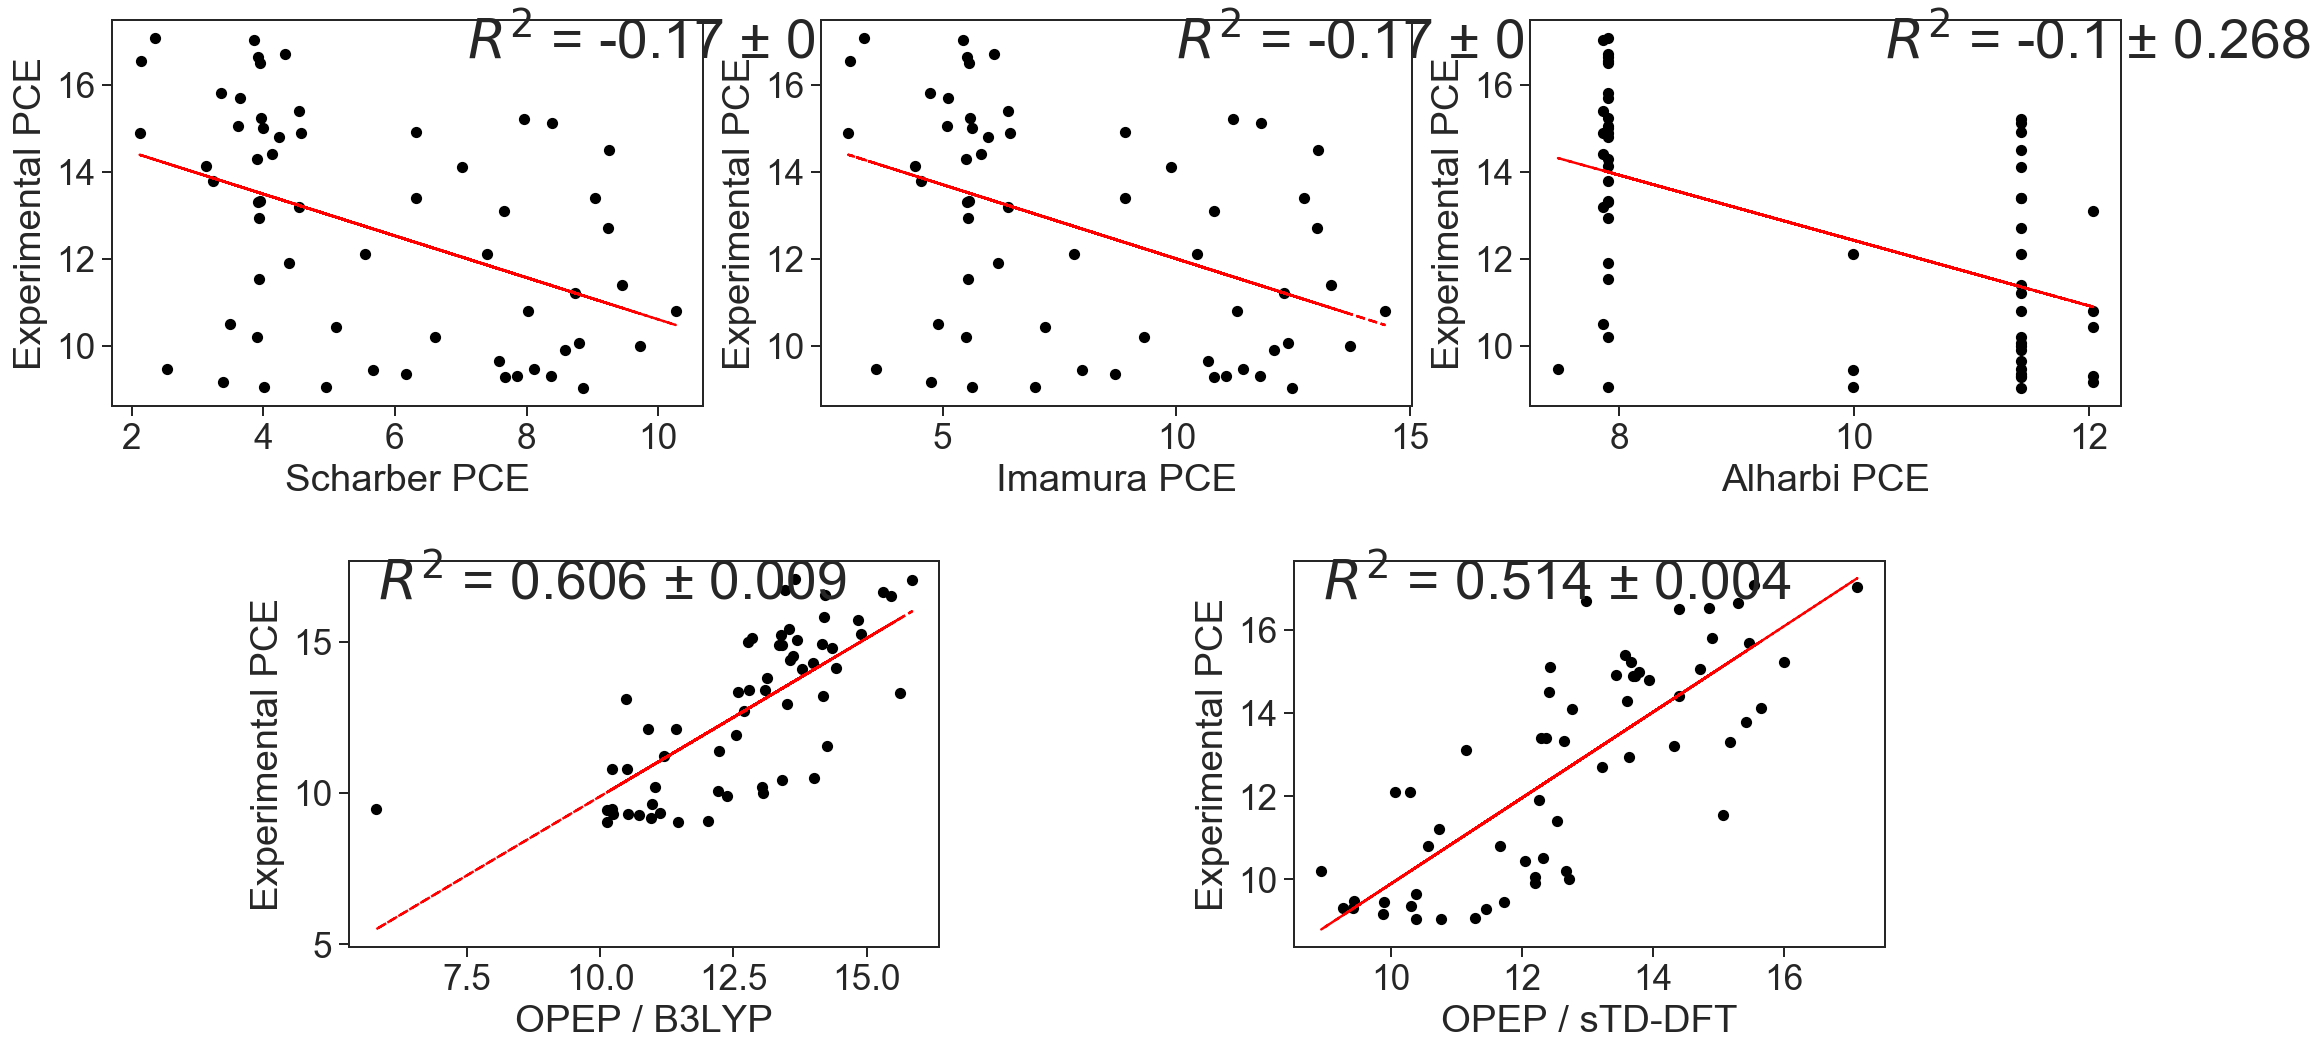

In [65]:
fig = plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid(shape=(2,9), loc=(0,0), colspan=3)
ax2 = plt.subplot2grid((2,9), (0,3), colspan=3)
ax3 = plt.subplot2grid((2,9), (0,6), colspan=3)
ax4 = plt.subplot2grid((2,9), (1,1), colspan=3)
ax5 = plt.subplot2grid((2,9), (1,5), colspan=3)

make_scatter_plot(ax1,'ScharberPCEdon', 'ExperimentalPCE', 'Scharber PCE', 'Experimental PCE',df = True, trendline=True)
make_scatter_plot(ax2,'ImamuraPCEdon', 'ExperimentalPCE', 'Imamura PCE', 'Experimental PCE', df  = True, trendline=True)
make_scatter_plot(ax3,'AlharbiPCEDon', 'ExperimentalPCE', 'Alharbi PCE', 'Experimental PCE', df  = True, trendline=True)
make_scatter_plot(ax4,LassoPCE_sTD_highPCE[-1], df_highPCE['ExperimentalPCE'], 'OPEP / B3LYP', 'Experimental PCE', trendline=True)
make_scatter_plot(ax5,LassoPCE_highPCE[-1], df_highPCE['ExperimentalPCE'], 'OPEP / sTD-DFT', 'Experimental PCE', trendline=True)

plt.tight_layout()
plt.subplots_adjust(top = 0.93, wspace = 1, hspace = 0.4)
plt.savefig('../figures/correlations_hightPCE.svg')
plt.savefig('../figures/correlations_hightPCE.png')
plt.show()
    

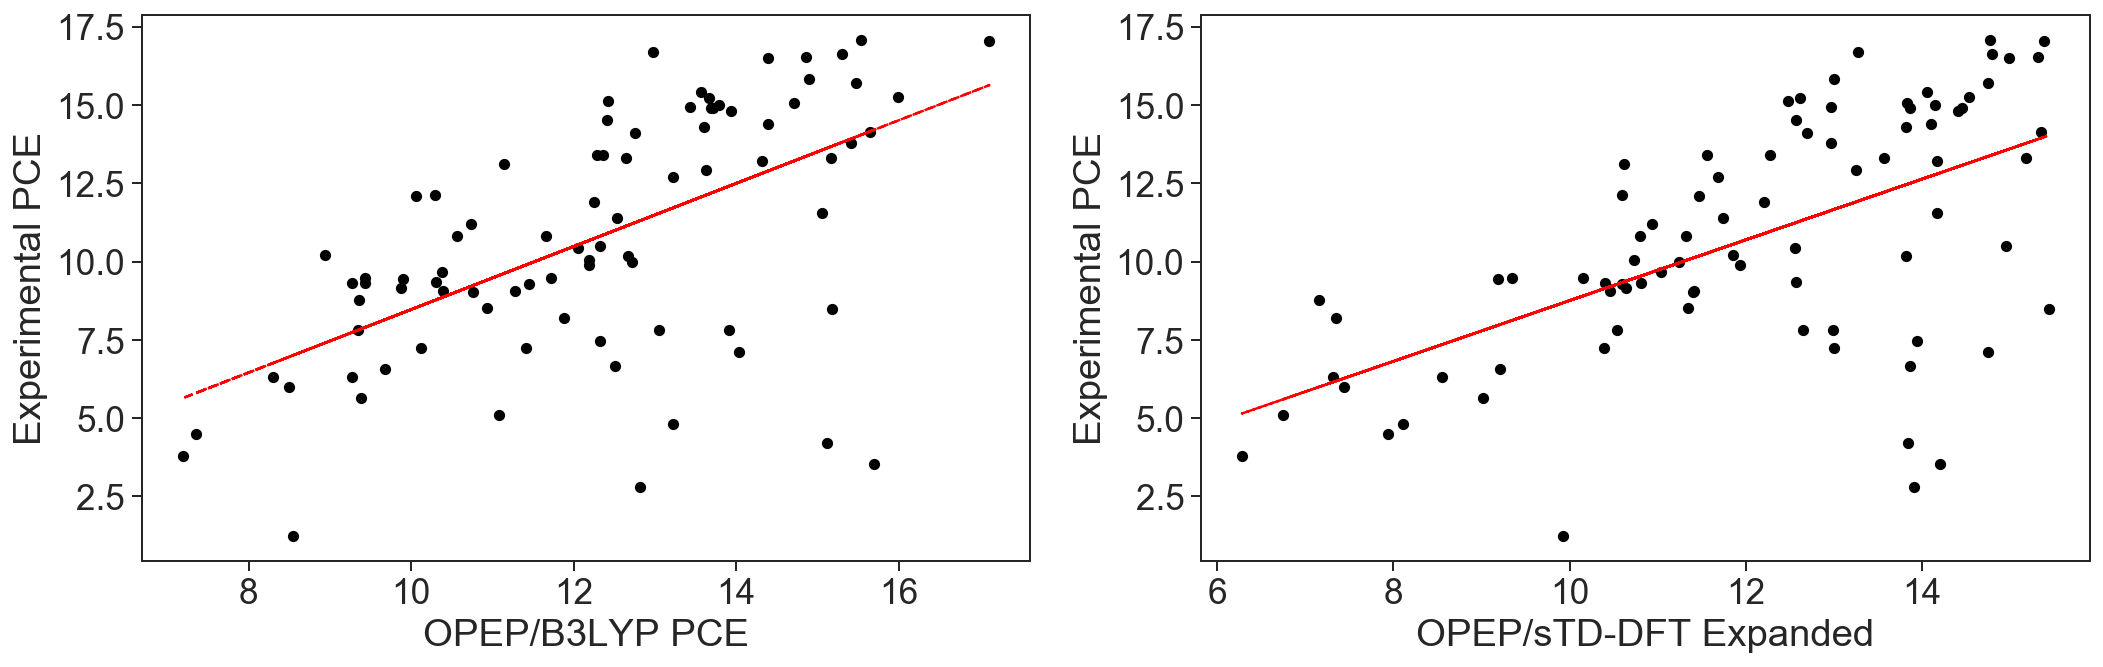

In [82]:
# scatter plots showing how the models (trained on high PCE), perform on all ranges of PCE

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

sTDDFT_expanded_PCE = []
B3LYP_PCE = []
experimental_PCE = []

for index, row in df.iterrows():
    sTDDFT_expanded_eq = -33.43031940760895 + (1.591193155740298 * row['sTDDFTsummedoscs']) + (-0.5118898619959514 * row['donsTDDFTsummedoscs'])+ (0.18137571355542534 * row['donsTDDFTabsFOM'])+ (2.8184968048085444 * row['sTDDFTDonElectrodonating'])+ ( 0.00109879100840529 * row['sTDDFTdonfirstengtranswavenumber'])+ (-1.0275614940393634 * row['sTDDFTaccfirstoscs'])
    sTDDFT_expanded_PCE.append(sTDDFT_expanded_eq)
    
    B3LYP_eq = -55.438270931405 + (-0.005321284140584486 * row['Polarizability']) + (-4.899789277587853 * row['DonSumOscStr']) + (5.68575624005491 * row['DonElectrodonating']) + (0.16626001827074613 * row['AbsFOM']) + (-0.4937808162326249 * row['acc_first_oscs']) + ( 0.0017262863787539922 * row['don_lowest_transition_wavenumber'])
    B3LYP_PCE.append(B3LYP_eq)
    
    experimental_PCE.append(row['ExperimentalPCE'])
    
ax1.scatter(B3LYP_PCE, experimental_PCE, c='black')
ax1.set_xlabel('OPEP/B3LYP PCE') 
ax1.set_ylabel('Experimental PCE')

# calc the trendline
z = np.polyfit(B3LYP_PCE, experimental_PCE, 1)
p = np.poly1d(z)
ax1.plot(B3LYP_PCE,p(B3LYP_PCE),"r--")
    
ax2.scatter(sTDDFT_expanded_PCE, experimental_PCE, c='black')
ax2.set_xlabel('OPEP/sTD-DFT Expanded') 
ax2.set_ylabel('Experimental PCE')

# calc the trendline
z = np.polyfit(sTDDFT_expanded_PCE, experimental_PCE, 1)
p = np.poly1d(z)
ax2.plot(sTDDFT_expanded_PCE,p(sTDDFT_expanded_PCE),"r--")

plt.tight_layout()
plt.savefig('../figures/correlation_highPCEmodels_vs_allPCE.png')
plt.show()

## Plots to compare models

In [371]:
def AbsoluteError(predicted, experimental, percent_error = False):
    # predicted is the predicted values. Ex: df['ScharberFF']
    # experimental is the target experimental values. Ex: df['ExperimentalFF']
    #
    # returns are list of errors
    
    absolute_errors = []
    for x in range(len(experimental)):
        if percent_error == True:
            absolute_errors.append(((predicted[x] - experimental[x])/experimental[x])*100)
        else:
            absolute_errors.append(predicted[x] - experimental[x])
    return absolute_errors

def make_violinplot(ax, error_list, label_list, title, matchcolor=False):
    # ax is which axes on the figure you want. Ex: ax1
    # error_list is the list of deviations Ex. FF_err_list
    # label_list is the list of labels for x-axis. Make sure it is same order as error_list
    # y_min and y_max are the limits for the y-axis
    # title is a string for subplot titles. Ex: 'FF'
    #
    # returns a plt object

    ax.grid(b = True, axis = 'y', ls = '--')
    ax.axhline(y = 0, color = 'dimgrey', linestyle = ':')
    
    if matchcolor==True:
        if title == 'Jsc':
            Jsc_palette = [sns.husl_palette(10)[0], sns.husl_palette(10)[2], sns.husl_palette(10)[6], sns.husl_palette(10)[8]]
            sns.violinplot(data = error_list, showextrema = True, showmedians = True, palette = Jsc_palette, ax = ax)
        else:
            sns.violinplot(data = error_list, showextrema = True, showmedians = True, palette = 'husl', ax = ax)
    else:
        sns.violinplot(data = error_list, showextrema = True, showmedians = True, palette = 'husl', ax = ax)
    ax.set_xticklabels(label_list, rotation = 45, ha = 'right')
    ax.set_title(title, weight = 'bold')
    if title == 'FF':
        ax.set_ylabel('Deviation (%)')
    elif title == 'Voc':
        ax.set_ylabel('Deviation (V)')
    elif title == 'Jsc':
        ax.set_ylabel('Deviation (mA/cm^2)')
    elif title == 'PCE':
        ax.set_ylabel('Deviation (%)')
    
    return plt


### Violin plot of FF, Voc, Jsc, and PCE with deviations (predicted - experimental) for all PCEs

In [372]:
ScharberFFerr = AbsoluteError(df['ScharberFF'], df['ExperimentalFF'])
AlharbiFFDonerr = AbsoluteError(df['AlharbiFFDon'], df['ExperimentalFF'])
AlharbiFFAccerr = AbsoluteError(df['AlharbiFFAcc'], df['ExperimentalFF'])
ImamuraFFerr = AbsoluteError(df['ImamuraFF'], df['ExperimentalFF'])
HutchFFerr = AbsoluteError(LassoFF[-1], df['ExperimentalFF'])
HutchFF_sTD_err = AbsoluteError(LassoFF_sTD[-1], df['ExperimentalFF'])
HutchFF_sTD_all_err = AbsoluteError(LassoFF_sTD_all[-1], df_sTD['ExperimentalFF'])

FF_err_list = [ScharberFFerr, ImamuraFFerr, AlharbiFFDonerr, AlharbiFFAccerr,  HutchFFerr, HutchFF_sTD_err, HutchFF_sTD_all_err]
FF_list = ['Scharber','Imamura', 'Alharbi (Don)', 'Alharbi (Acc)', 'OPEP / B3LYP', 'OPEP / sTD-DFT', 'OPEP / sTD-DFT (expanded)']


AlharbiVocAccErr = AbsoluteError(df['AlharbiVocAcc'], df['ExperimentalVoc'])
AlharbiVocDonErr = AbsoluteError(df['AlharbiVocDon'], df['ExperimentalVoc'])
ImamuraVocErr = AbsoluteError(df['ImamuraVoc'], df['ExperimentalVoc'])
ScharberVocErr = AbsoluteError(df['ScharberVoc'], df['ExperimentalVoc'])
HutchVocerr = AbsoluteError(LassoVoc[-1], df['ExperimentalVoc'])
HutchVoc_sTD_err = AbsoluteError(LassoVoc_sTD[-1], df['ExperimentalVoc'])
HutchVoc_sTD_all_err = AbsoluteError(LassoVoc_sTD_all[-1], df_sTD['ExperimentalVoc'])

Voc_err_list = [ScharberVocErr,ImamuraVocErr, AlharbiVocDonErr, AlharbiVocAccErr, HutchVocerr, HutchVoc_sTD_err, HutchVoc_sTD_all_err]
Voc_list = ['Scharber','Imamura','Alharbi (Don)', 'Alharbi (Acc)', 'OPEP / B3LYP', 'OPEP / sTD-DFT', 'OPEP / sTD-DFT (expanded)']


ScharberJscAccErr = AbsoluteError(df['ScharberJscAcc'], df['ExperimentalJsc'])
ImamuraTotalJscErr = AbsoluteError(df['ImamuraTotalJsc'], df['ExperimentalJsc'])
ImamuraJscAccErr = AbsoluteError(df['ImamuraJscAcc'], df['ExperimentalJsc'])
ImamuraJscDonErr = AbsoluteError(df['ImamuraJscDon'], df['ExperimentalJsc'])
ScharberTotalJscErr = AbsoluteError(df['ScharberTotalJsc'], df['ExperimentalJsc'])
ScharberJscDonErr = AbsoluteError(df['ScharberJscDon'], df['ExperimentalJsc'])
ScharberJsclowestoptbgErr = AbsoluteError(df['ScharberJsclowestoptbg'], df['ExperimentalJsc'])
HutchJscerr = AbsoluteError(LassoJsc[-1], df['ExperimentalJsc'])
HutchJsc_sTD_err = AbsoluteError(LassoJsc_sTD[-1], df['ExperimentalJsc'])
HutchJsc_sTD_all_err = AbsoluteError(LassoJsc_sTD_all[-1], df_sTD['ExperimentalJsc'])

Jsc_err_list = [ScharberJscDonErr,ScharberJscAccErr, ScharberTotalJscErr, ScharberJsclowestoptbgErr, ImamuraJscDonErr,ImamuraJscAccErr, ImamuraTotalJscErr, HutchJscerr, HutchJsc_sTD_err, HutchJsc_sTD_all_err]
Jsc_list = ['Scharber (Don)', 'Scharber (Acc)', 'Scharber (Total)', 'Scharber (Low Eg)', 'Imamura (Don)','Imamura (Acc)','Imamura (Total)', 'OPEP / B3LYP', 'OPEP / sTD-DFT', 'OPEP / sTD-DFT (expanded)']


SchPCEdonErr = AbsoluteError(df['ScharberPCEdon'], df['ExperimentalPCE'])
SchPCEaccErr = AbsoluteError(df['ScharberPCEacc'], df['ExperimentalPCE'])
SchPCEtotalErr = AbsoluteError(df['ScharberPCEtotal'], df['ExperimentalPCE'])
SchPCElowbgErr = AbsoluteError(df['ScharberPCElowestoptbg'], df['ExperimentalPCE'])
ImamuraPCEdonErr = AbsoluteError(df['ImamuraPCEdon'], df['ExperimentalPCE'])
ImamuraPCEaccErr = AbsoluteError(df['ImamuraPCEacc'], df['ExperimentalPCE'])
ImamuraPCEtotErr = AbsoluteError(df['ImamuraPCEtotal'], df['ExperimentalPCE'])
AlharbiPCEDonErr = AbsoluteError(df['AlharbiPCEDon'], df['ExperimentalPCE'])
AlharbiPCEAccErr = AbsoluteError(df['AlharbiPCEAcc'], df['ExperimentalPCE'])
HutchPCEerr = AbsoluteError(LassoPCE[-1], df['ExperimentalPCE'])
HutchPCE_sTD_err = AbsoluteError(LassoPCE_sTD[-1], df['ExperimentalPCE'])
HutchPCE_sTD_all_err = AbsoluteError(LassoPCE_sTD_all[-1], df_sTD['ExperimentalPCE'])
HutchisonLassoCalcErr = AbsoluteError(HutchLassoCalc, df['ExperimentalPCE'])
HutchisonLassoFF70Err = AbsoluteError(HutchLassoFF70, df['ExperimentalPCE'])
HutchLassoCalc_sTD_Err = AbsoluteError(HutchLassoCalc_sTD, df['ExperimentalPCE'])
HutchLassoFF70_sTD_Err = AbsoluteError(HutchLassoFF70_sTD, df['ExperimentalPCE'])
HutchLassoCalc_sTD_all_Err = AbsoluteError(HutchLassoCalc_sTD_all, df_sTD['ExperimentalPCE'])
HutchLassoFF70_sTD_all_Err = AbsoluteError(HutchLassoFF70_sTD_all, df_sTD['ExperimentalPCE'])

PCE_err_list = [SchPCEdonErr, SchPCEaccErr, SchPCEtotalErr,SchPCElowbgErr, ImamuraPCEdonErr,ImamuraPCEaccErr, ImamuraPCEtotErr, AlharbiPCEDonErr, AlharbiPCEAccErr, HutchPCEerr, HutchPCE_sTD_err, HutchPCE_sTD_all_err, HutchisonLassoCalcErr, HutchLassoCalc_sTD_Err, HutchLassoCalc_sTD_all_Err]
PCE_list = ['Scharber (Don)', 'Scharber (Acc)', 'Scharber (total)', 'Scharber (lowest Eg)', 'Imamura (Don)', 'Imamura (Acc)', 'Imamura (total)', 'modified Alharbi (Don)', 'modified Alharbi (Acc)', 'OPEP / B3LYP' , 'OPEP / sTD-DFT', 'OPEP / sTD-DFT (expanded)', 'OPEP / B3LYP (calc.)', 'OPEP / sTD-DFT (calc.)', 'OPEP / sTD-DFT (expanded calc.)' ]

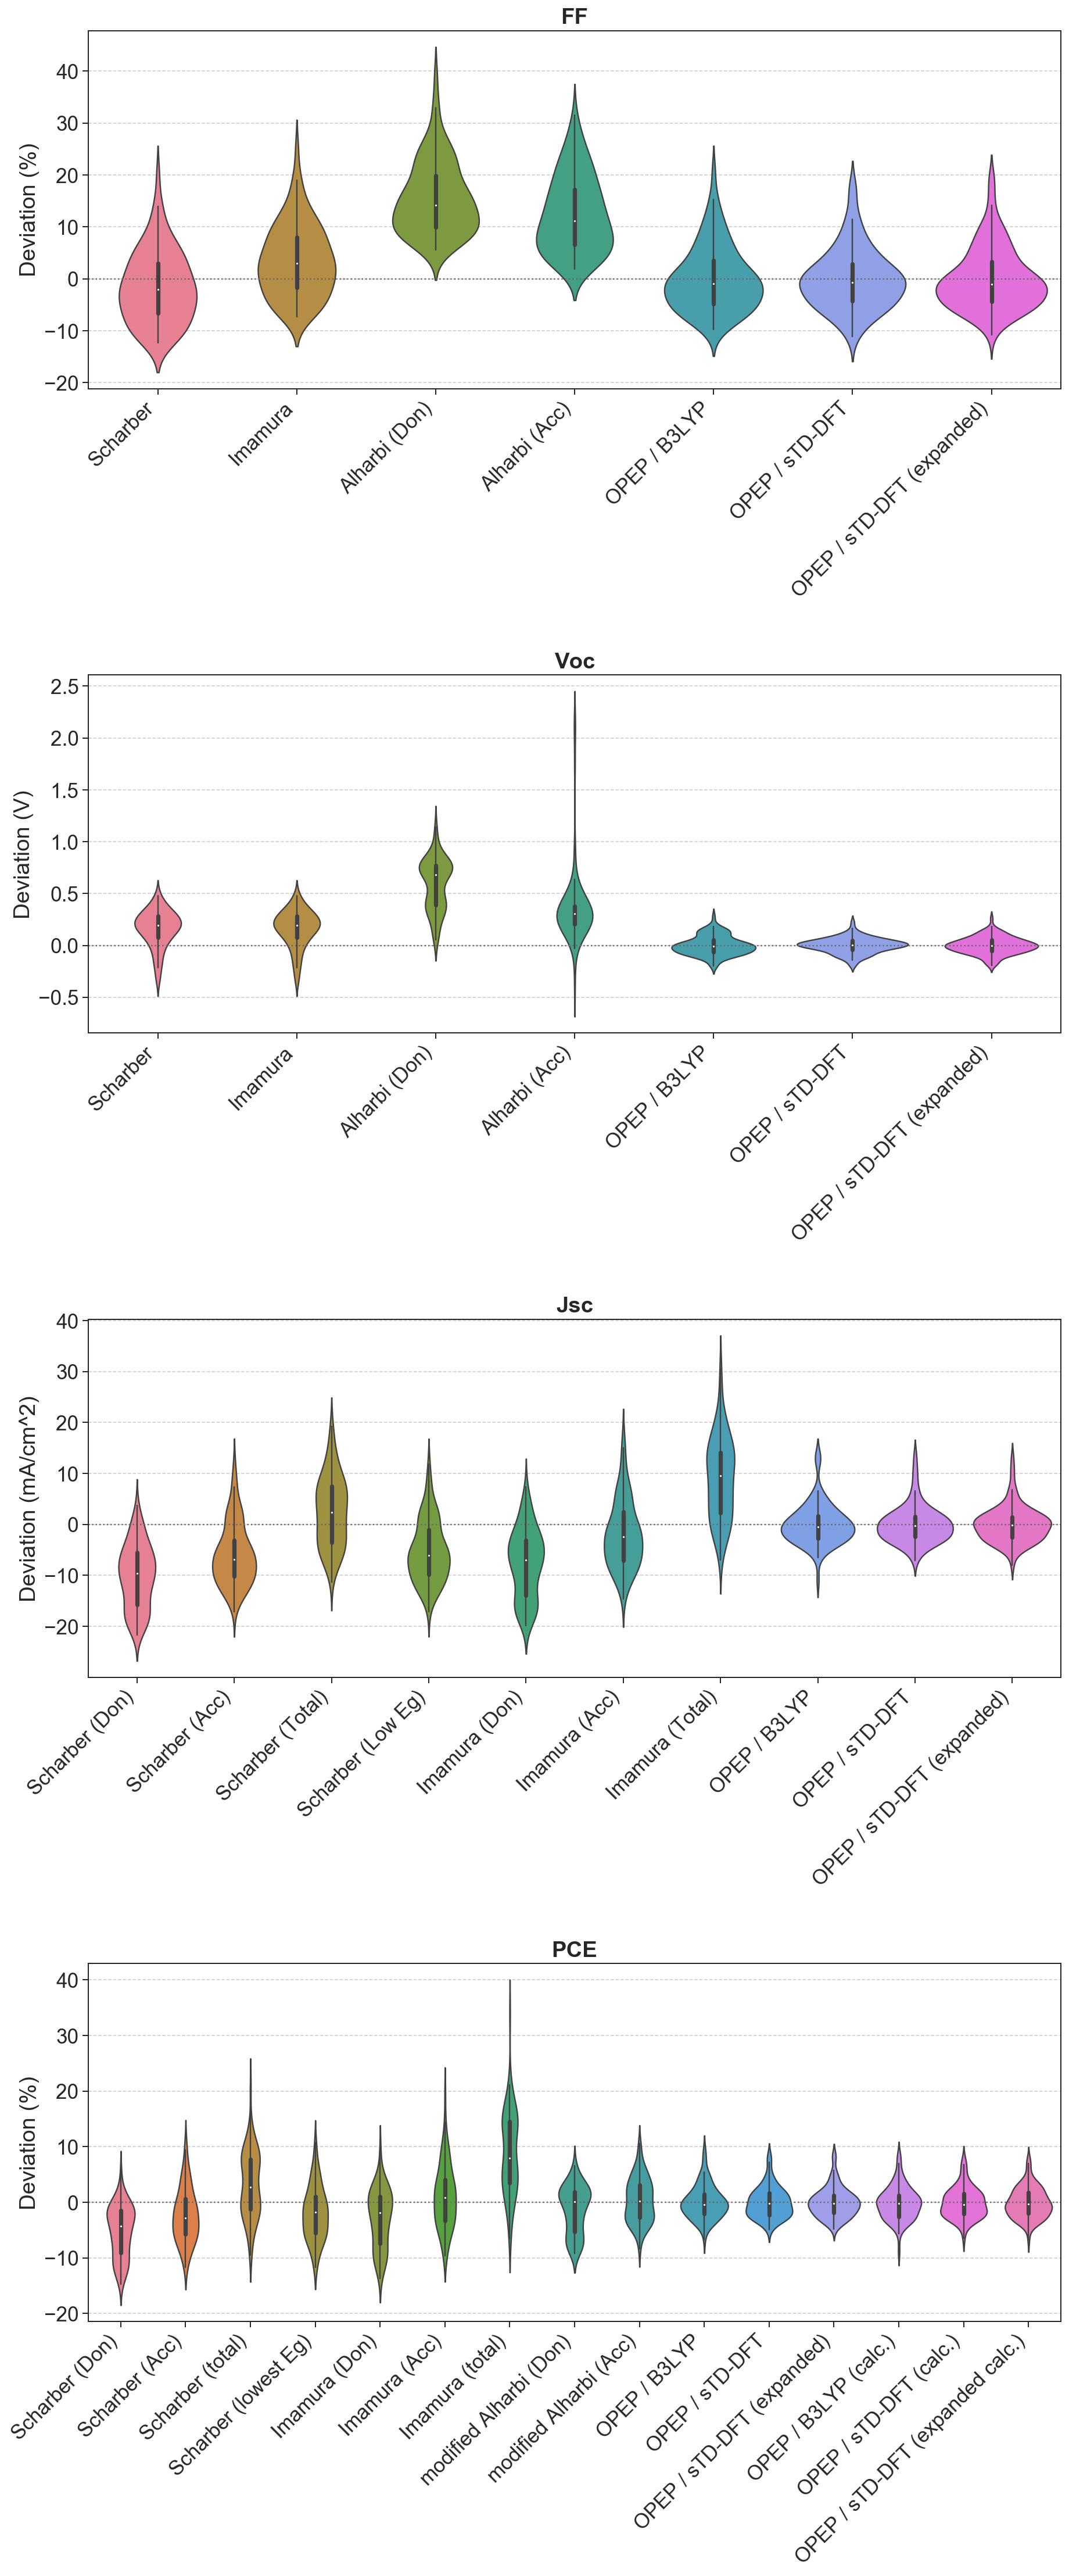

In [373]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (15, 34))

make_violinplot(ax1,FF_err_list, FF_list, 'FF' )
make_violinplot(ax2, Voc_err_list, Voc_list, 'Voc')
make_violinplot(ax3, Jsc_err_list, Jsc_list, 'Jsc')
make_violinplot(ax4, PCE_err_list, PCE_list,'PCE')

plt.subplots_adjust(top = 0.93, wspace = 0.3, hspace = 0.8)
#plt.tight_layout()
plt.savefig('../figures/violinplots_all_models.pdf')
plt.savefig('../figures/violinplots_all_models.png', dpi = 300)
plt.show()

### Violin plots of FF, Voc, Jsc, and PCE with deviations for experimetnal PCEs > 9%

In [374]:
ScharberFFerr = AbsoluteError(df_highPCE['ScharberFF'], df_highPCE['ExperimentalFF'])
AlharbiFFDonerr = AbsoluteError(df_highPCE['AlharbiFFDon'], df_highPCE['ExperimentalFF'])
ImamuraFFerr = AbsoluteError(df_highPCE['ImamuraFF'], df_highPCE['ExperimentalFF'])
HutchFFerr = AbsoluteError(LassoFF_highPCE[-1], df_highPCE['ExperimentalFF'])
HutchFF_sTD_err = AbsoluteError(LassoFF_sTD_highPCE[-1], df_highPCE['ExperimentalFF'])

FF_err_list_highPCE = [ScharberFFerr,ImamuraFFerr, AlharbiFFDonerr, HutchFFerr, HutchFF_sTD_err]
FF_list = ['Scharber', 'Imamura', 'Alharbi','OPEP / B3LYP', 'OPEP / sTD-DFT']


AlharbiVocDonErr = AbsoluteError(df_highPCE['AlharbiVocDon'], df_highPCE['ExperimentalVoc'])
ImamuraVocErr = AbsoluteError(df_highPCE['ImamuraVoc'], df_highPCE['ExperimentalVoc'])
ScharberVocErr = AbsoluteError(df_highPCE['ScharberVoc'], df_highPCE['ExperimentalVoc'])
HutchVocerr = AbsoluteError(LassoVoc_highPCE[-1], df_highPCE['ExperimentalVoc'])
HutchVoc_sTD_err = AbsoluteError(LassoVoc_sTD_highPCE[-1], df_highPCE['ExperimentalVoc'])

Voc_err_list_highPCE = [ScharberVocErr, ImamuraVocErr, AlharbiVocDonErr, HutchVocerr, HutchVoc_sTD_err]
Voc_list = ['Scharber', 'Imamura', 'Alharbi', 'OPEP / B3LYP', 'OPEP / sTD-DFT']


ImamuraJscDonErr = AbsoluteError(df_highPCE['ImamuraJscDon'], df_highPCE['ExperimentalJsc'])
ScharberJscDonErr = AbsoluteError(df_highPCE['ScharberJscDon'], df_highPCE['ExperimentalJsc'])
HutchJscerr = AbsoluteError(LassoJsc_highPCE[-1], df_highPCE['ExperimentalJsc'])
HutchJsc_sTD_err = AbsoluteError(LassoJsc_sTD_highPCE[-1], df_highPCE['ExperimentalJsc'])

Jsc_err_list_highPCE = [ScharberJscDonErr, ImamuraJscDonErr, HutchJscerr, HutchJsc_sTD_err]
Jsc_list = ['Scharber', 'Imamura', 'OPEP / B3LYP', 'OPEP / sTD-DFT']


SchPCEdonErr = AbsoluteError(df_highPCE['ScharberPCEdon'], df_highPCE['ExperimentalPCE']) 
ImamuraPCEdonErr = AbsoluteError(df_highPCE['ImamuraPCEdon'], df_highPCE['ExperimentalPCE'])
AlharbiPCEDonErr = AbsoluteError(df_highPCE['AlharbiPCEDon'], df_highPCE['ExperimentalPCE'])
HutchPCEerr = AbsoluteError(LassoPCE_highPCE[-1], df_highPCE['ExperimentalPCE'])
HutchPCE_sTD_err = AbsoluteError(LassoPCE_sTD_highPCE[-1], df_highPCE['ExperimentalPCE'])
HutchPCE_sTD_all_err = AbsoluteError(LassoPCE_sTD_highPCE_all[-1], df_sTD_highPCE['ExperimentalPCE'])

PCE_err_list_highPCE = [SchPCEdonErr, ImamuraPCEdonErr,AlharbiPCEDonErr, HutchPCEerr, HutchPCE_sTD_err]
PCE_list = ['Scharber', 'Imamura', 'modified Alharbi', 'OPEP / B3LYP' , 'OPEP / sTD-DFT']

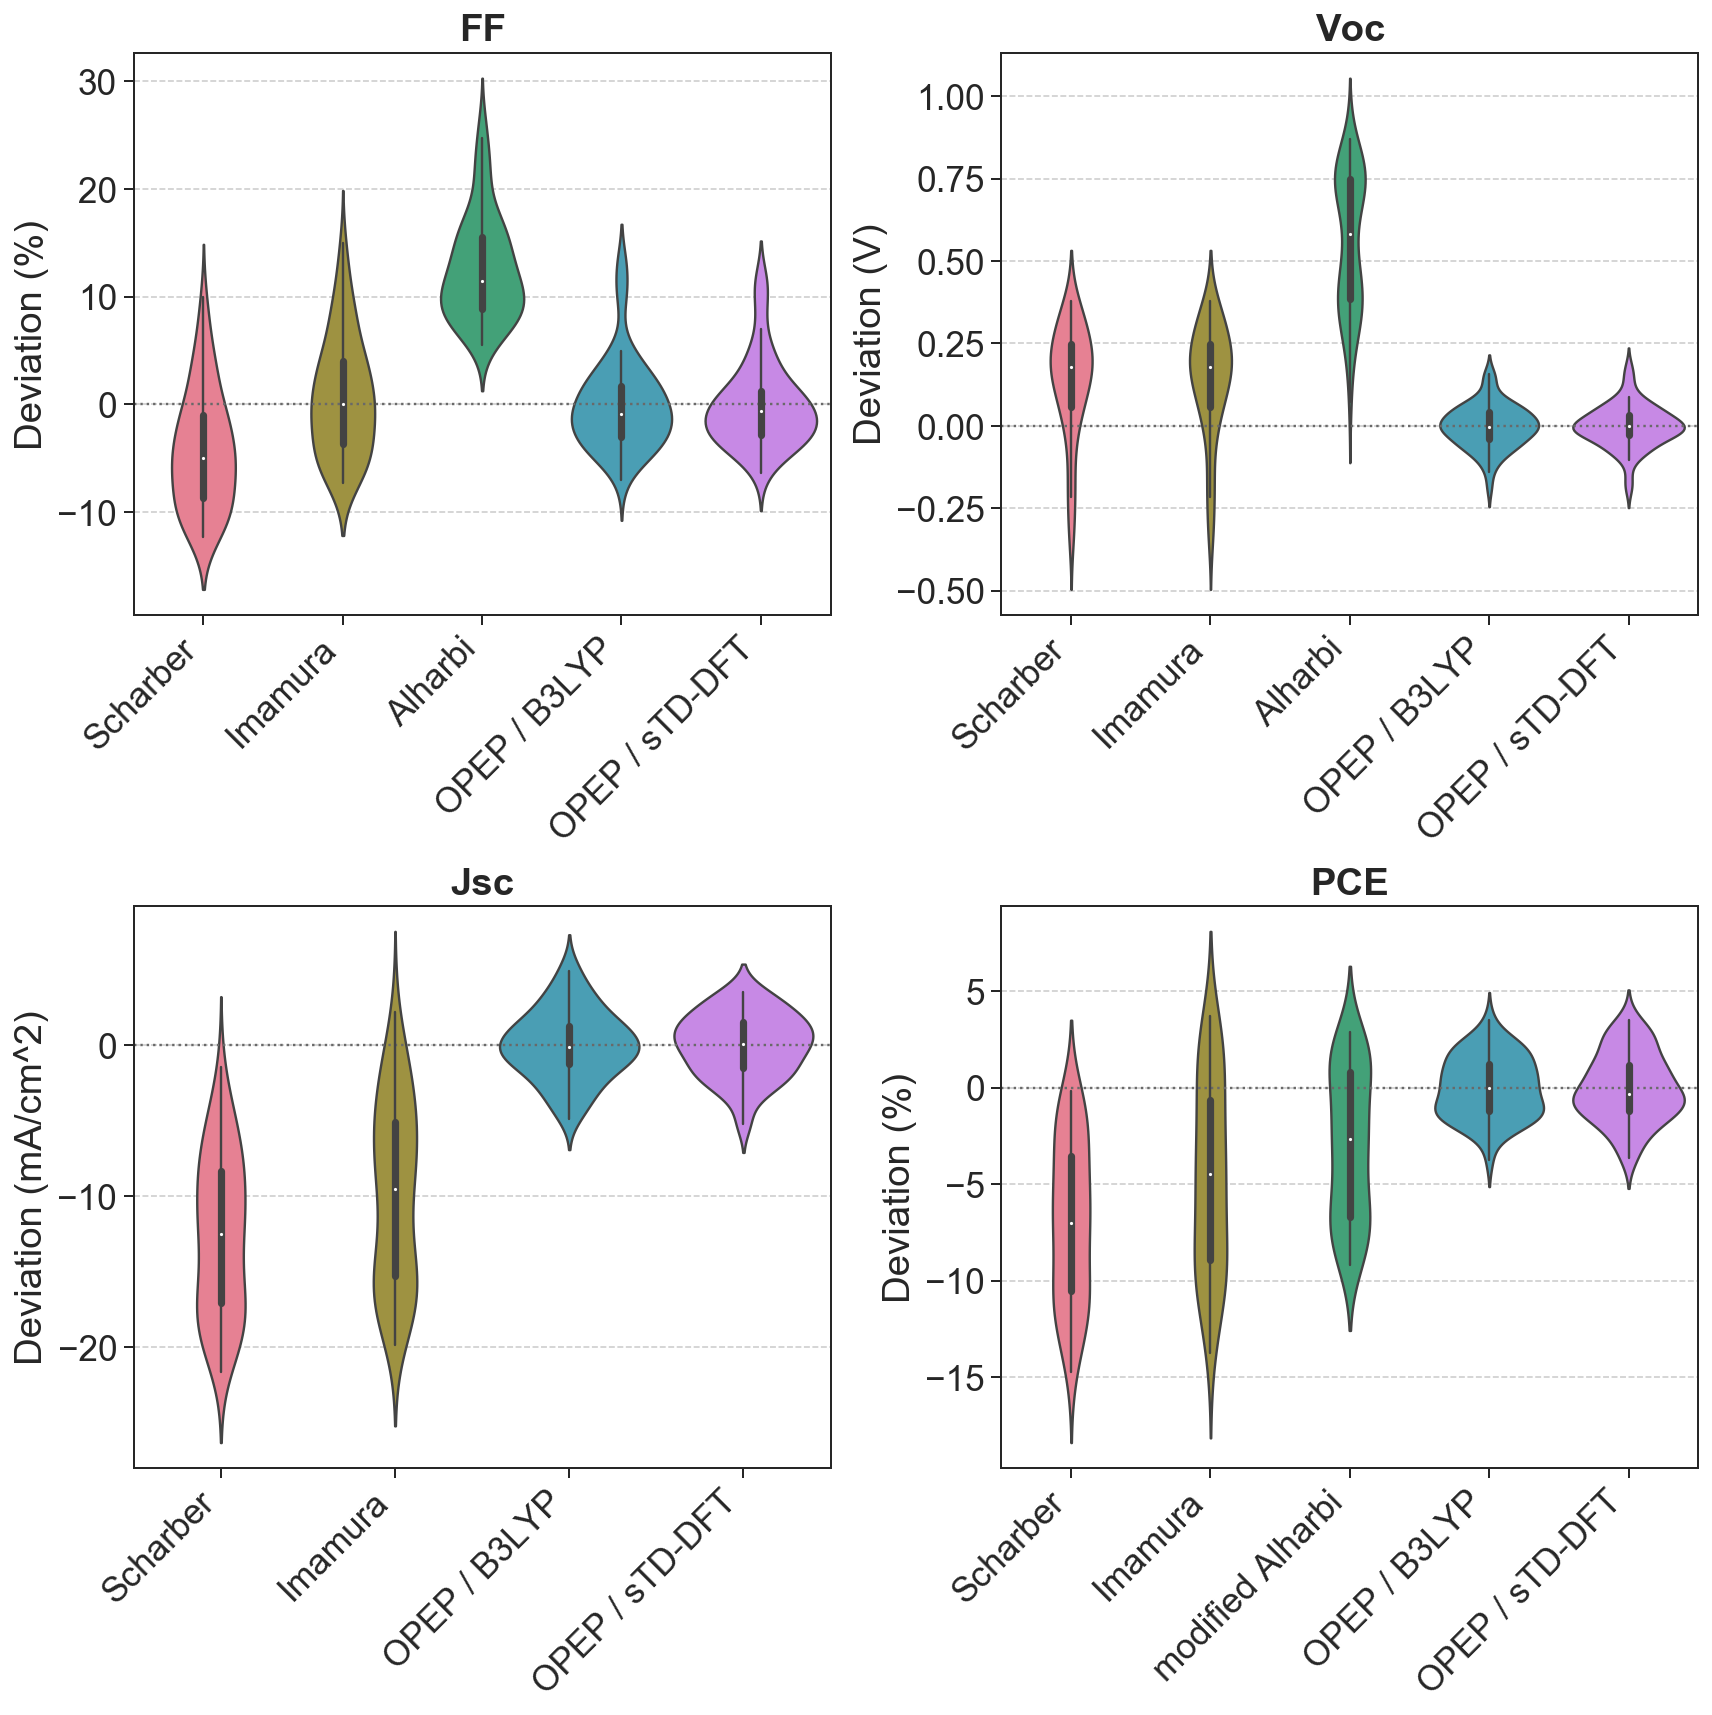

In [375]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12, 12))

make_violinplot(ax1,FF_err_list_highPCE, FF_list, 'FF' )
make_violinplot(ax2, Voc_err_list_highPCE, Voc_list, 'Voc')
make_violinplot(ax3, Jsc_err_list_highPCE, Jsc_list, 'Jsc', matchcolor = True)
make_violinplot(ax4, PCE_err_list_highPCE, PCE_list,'PCE')

plt.subplots_adjust(top = 0.93, wspace = 0.3, hspace = 0.8)
plt.tight_layout()
plt.savefig('../figures/violinplots_highPCE.png', dpi = 300)
plt.show()

## Correlation plots between DFT and sTD-DFT

In [376]:
def scatter_plot_df(feature, target, df, xlabel, ylabel):
    fig, ax = plt.subplots()
    x = df[feature]
    y = df[target]
    ax.scatter(x, y, c='black') 
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes

    ax.plot(lims, lims, 'c--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.show()

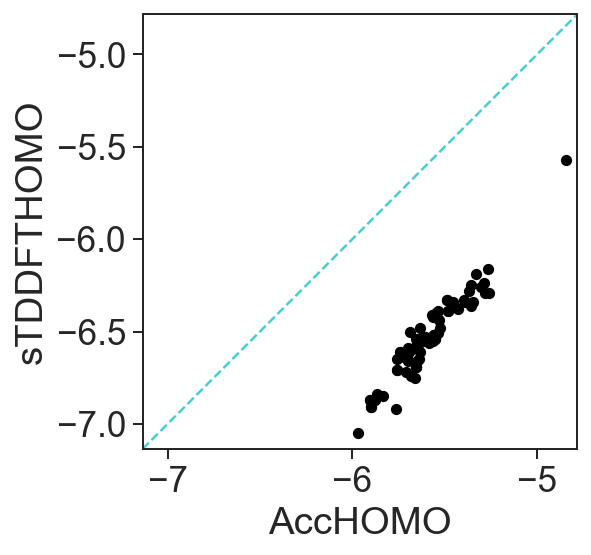

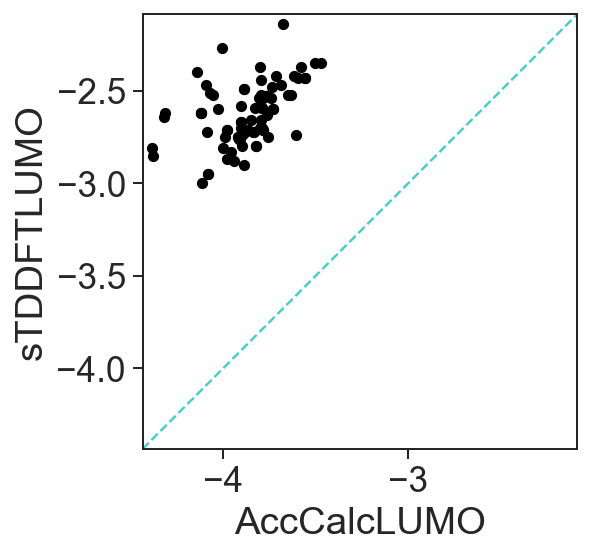

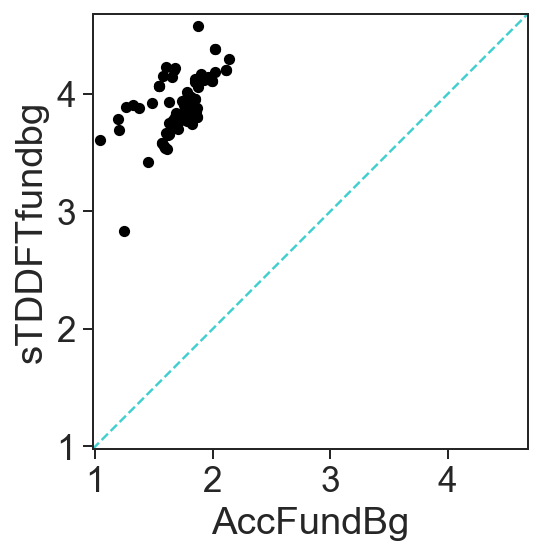

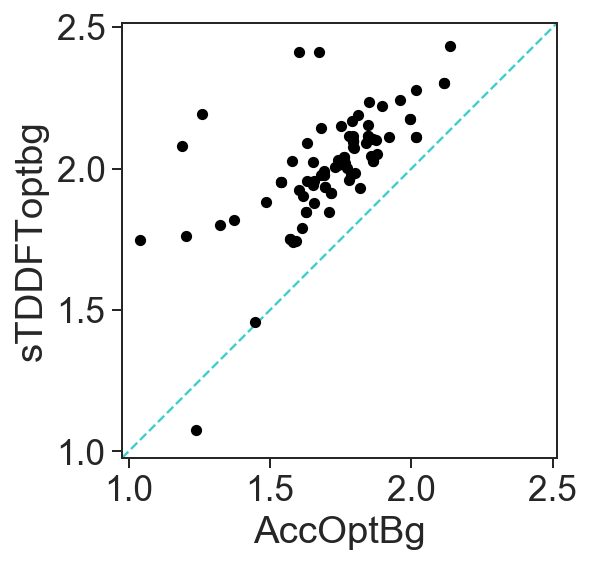

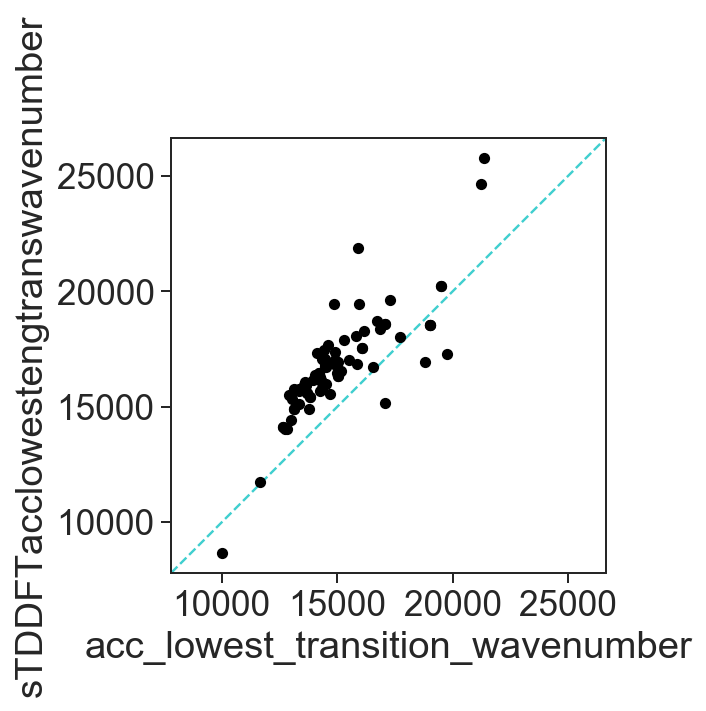

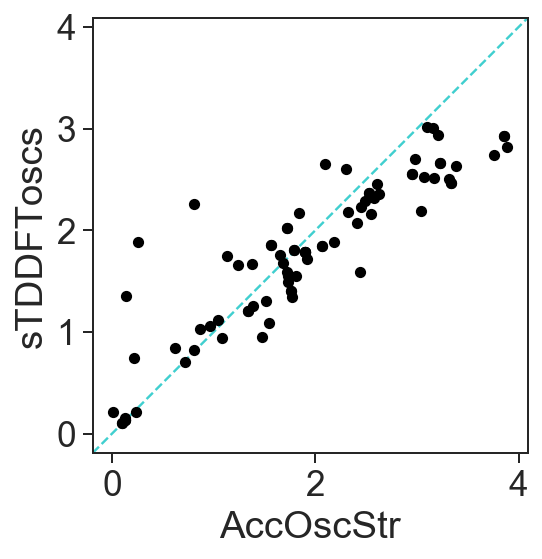

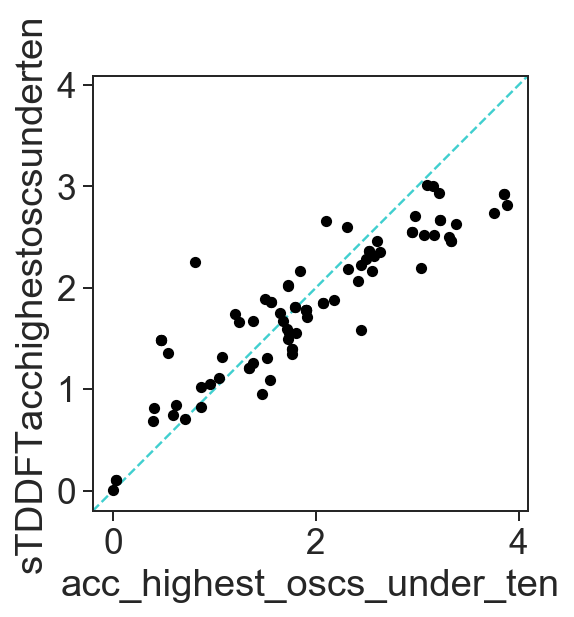

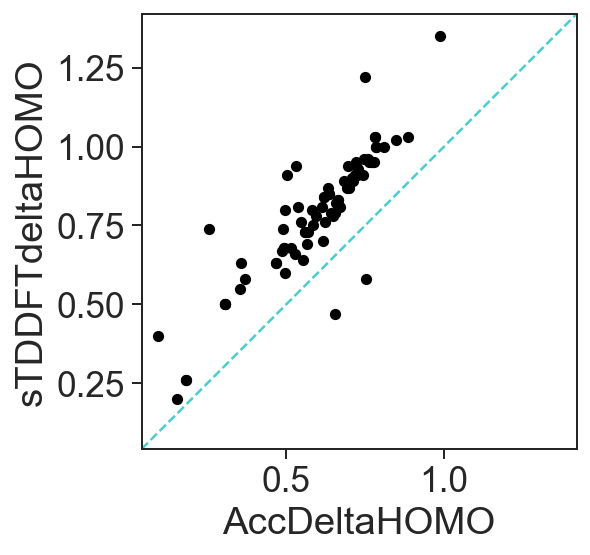

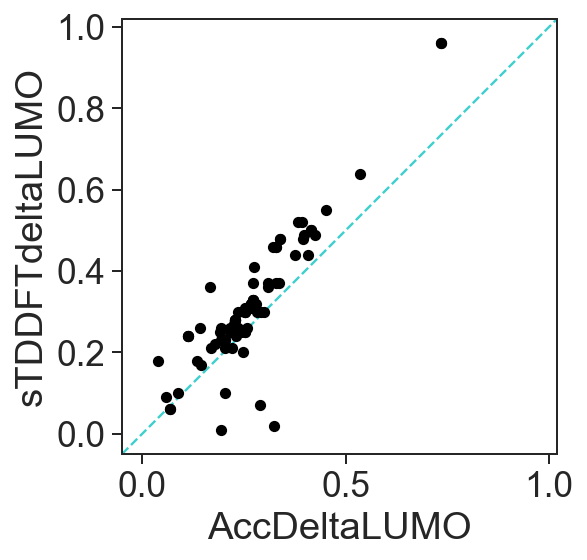

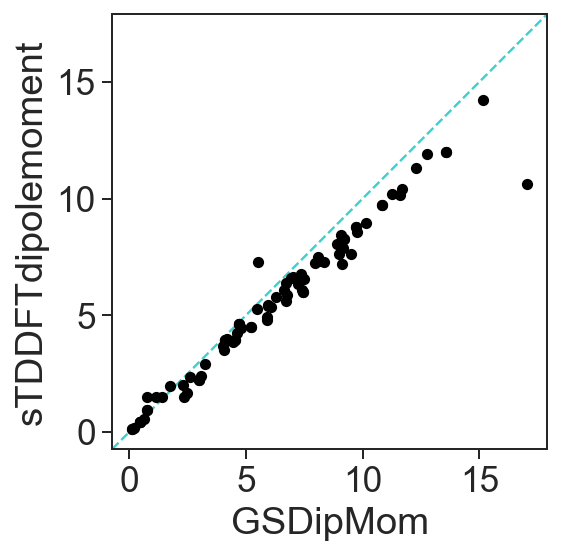

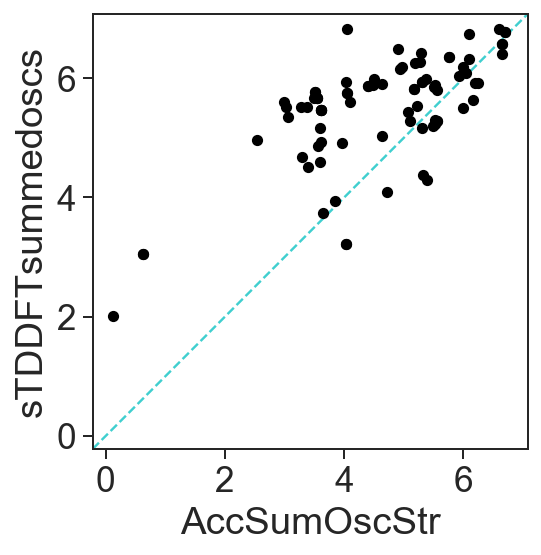

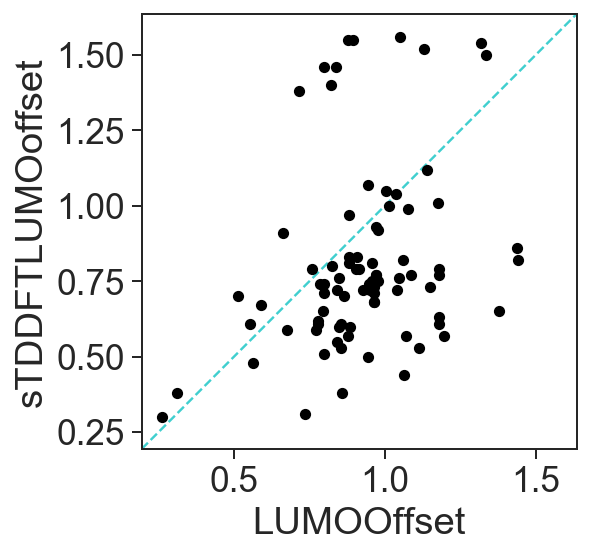

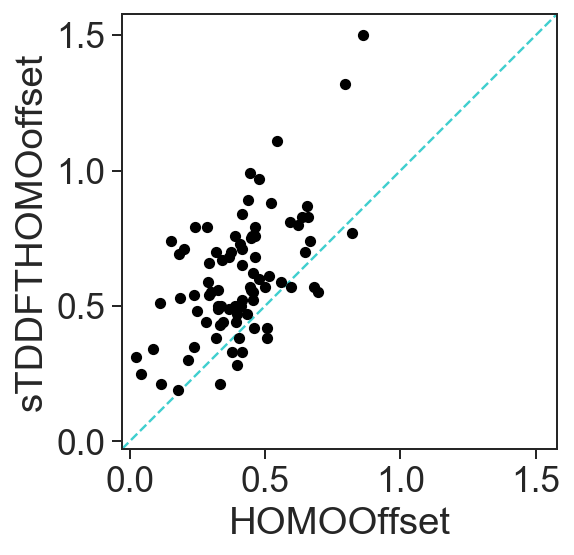

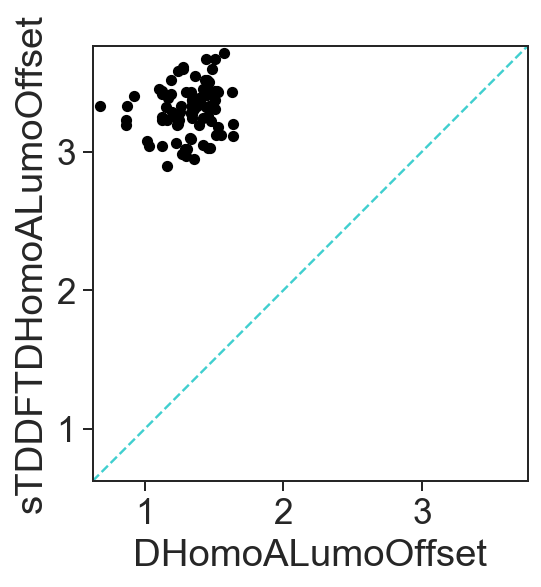

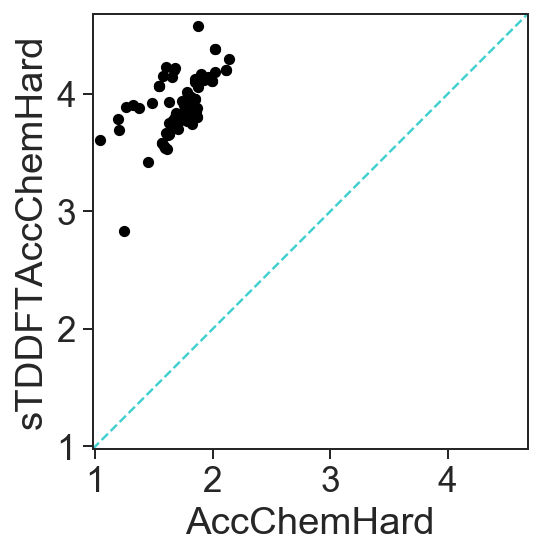

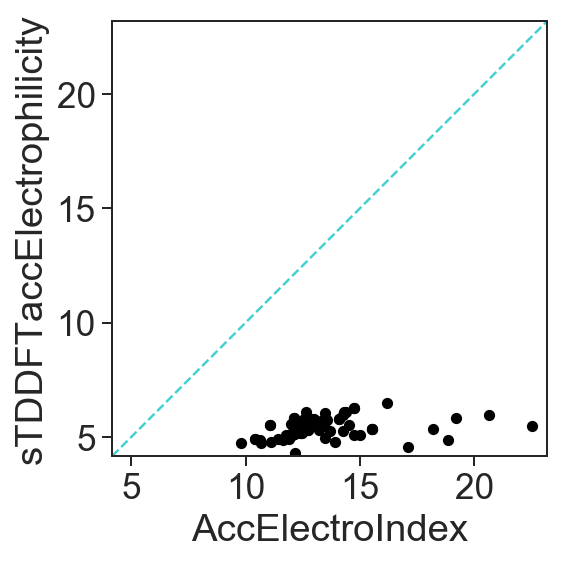

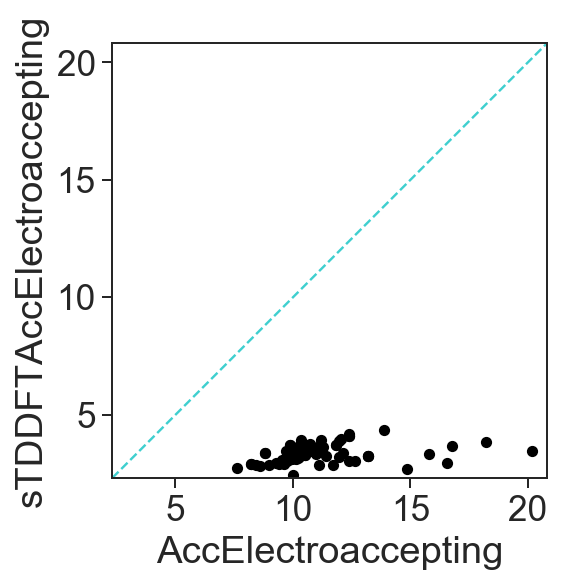

In [377]:
scatter_plot_df('AccHOMO', 'sTDDFTHOMO', df, 'AccHOMO', 'sTDDFTHOMO')
scatter_plot_df('AccCalcLUMO', 'sTDDFTLUMO', df, 'AccCalcLUMO', 'sTDDFTLUMO')
scatter_plot_df('AccFundBg', 'sTDDFTfundbg', df,'AccFundBg', 'sTDDFTfundbg')

scatter_plot_df('AccOptBg', 'sTDDFToptbg', df,'AccOptBg', 'sTDDFToptbg')
#scatter_plot_df('AccEnergyTransitioneV', 'sTDDFToptbg', df,'AccEnergyTransitioneV', 'sTDDFToptbg')
#scatter_plot_df('AccEnergyTransitioneV', 'sTDDFTacclowestengtranseV', df,'AccEnergyTransitioneV', 'sTDDFTacclowestengtranseV')
#scatter_plot_df('AccEnergyTransitioneV', 'sTDDFTaccfirstengtranseV', df,'AccEnergyTransitioneV', 'sTDDFTaccfirstengtranseV')

#scatter_plot_df('AccEnergyTransitionWavenumber', 'sTDDFToptbg', df,'AccEnergyTransitionWavenumber', 'sTDDFToptbg')
##scatter_plot_df('AccEnergyTransitionWavenumber', 'sTDDFTaccfirstengtranswavenumber', df,'AccEnergyTransitionWavenumber', 'sTDDFTaccfirstengtranswavenumber')

#scatter_plot_df('acc_lowest_transition_eV', 'sTDDFToptbg', df,'acc_lowest_transition_eV', 'sTDDFToptbg')
#scatter_plot_df('acc_lowest_transition_eV', 'sTDDFTacclowestengtranseV', df,'acc_lowest_transition_eV', 'sTDDFTacclowestengtranseV')
#scatter_plot_df('acc_lowest_transition_eV', 'sTDDFTaccfirstengtranseV', df,'acc_lowest_transition_eV', 'sTDDFTaccfirstengtranseV')
                
#scatter_plot_df('acc_lowest_transition_wavenumber', 'sTDDFToptbg', df,'acc_lowest_transition_wavenumber', 'sTDDFToptbg')
scatter_plot_df('acc_lowest_transition_wavenumber', 'sTDDFTacclowestengtranswavenumber', df,'acc_lowest_transition_wavenumber', 'sTDDFTacclowestengtranswavenumber')
#scatter_plot_df('acc_lowest_transition_wavenumber', 'sTDDFTaccfirstengtranswavenumber', df,'acc_lowest_transition_wavenumber', 'sTDDFTaccfirstengtranswavenumber')

scatter_plot_df('AccOscStr', 'sTDDFToscs', df,'AccOscStr', 'sTDDFToscs')
#scatter_plot_df('AccOscStr', 'sTDDFTaccfirstoscs', df,'AccOscStr', 'sTDDFTaccfirstoscs')
#scatter_plot_df('AccOscStr', 'sTDDFTacchighestoscsunderten', df,'AccOscStr', 'sTDDFTacchighestoscsunderten')
##scatter_plot_df('acc_first_oscs', 'sTDDFToscs', df,'acc_first_oscs', 'sTDDFToscs')
#scatter_plot_df('acc_first_oscs', 'sTDDFTaccfirstoscs', df,'acc_first_oscs', 'sTDDFTaccfirstoscs')
#scatter_plot_df('acc_first_oscs', 'sTDDFTacchighestoscsunderten', df,'acc_first_oscs', 'sTDDFTacchighestoscsunderten')
#scatter_plot_df('acc_highest_oscs_under_ten', 'sTDDFToscs', df,'acc_highest_oscs_under_ten', 'sTDDFToscs')
#scatter_plot_df('acc_highest_oscs_under_ten', 'sTDDFTaccfirstoscs', df,'acc_highest_oscs_under_ten', 'sTDDFTaccfirstoscs')
scatter_plot_df('acc_highest_oscs_under_ten', 'sTDDFTacchighestoscsunderten', df,'acc_highest_oscs_under_ten', 'sTDDFTacchighestoscsunderten')


scatter_plot_df('AccDeltaHOMO', 'sTDDFTdeltaHOMO', df,'AccDeltaHOMO', 'sTDDFTdeltaHOMO')
scatter_plot_df('AccDeltaLUMO', 'sTDDFTdeltaLUMO', df,'AccDeltaLUMO', 'sTDDFTdeltaLUMO')

scatter_plot_df('GSDipMom', 'sTDDFTdipolemoment', df,'GSDipMom', 'sTDDFTdipolemoment')

scatter_plot_df('AccSumOscStr', 'sTDDFTsummedoscs', df,'AccSumOscStr', 'sTDDFTsummedoscs')
scatter_plot_df('LUMOOffset', 'sTDDFTLUMOoffset', df,'LUMOOffset', 'sTDDFTLUMOoffset')
scatter_plot_df('HOMOOffset', 'sTDDFTHOMOoffset', df,'HOMOOffset', 'sTDDFTHOMOoffset')
scatter_plot_df('DHomoALumoOffset', 'sTDDFTDHomoALumoOffset', df,'DHomoALumoOffset', 'sTDDFTDHomoALumoOffset')

scatter_plot_df('AccChemHard', 'sTDDFTAccChemHard', df,'AccChemHard', 'sTDDFTAccChemHard')
scatter_plot_df('AccElectroIndex', 'sTDDFTaccElectrophilicity', df,'AccElectroIndex', 'sTDDFTaccElectrophilicity')
scatter_plot_df('AccElectroaccepting', 'sTDDFTAccElectroaccepting', df,'AccElectroaccepting', 'sTDDFTAccElectroaccepting')


 

In [378]:
def scatterplot_bigfig(feature, target, df, xlabel, ylabel, xyline=False, trendline=False, ax=False):
    x = df[feature]
    y = df[target]
    
    if ax == False:
        fig, ax = plt.subplots()
    ax.scatter(x, y, c='black') 
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    
    if trendline == True:
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        pylab.plot(x,p(x),"r--")

    if xyline == True:
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

        ax.plot(lims, lims, 'c--', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
    
    return plt

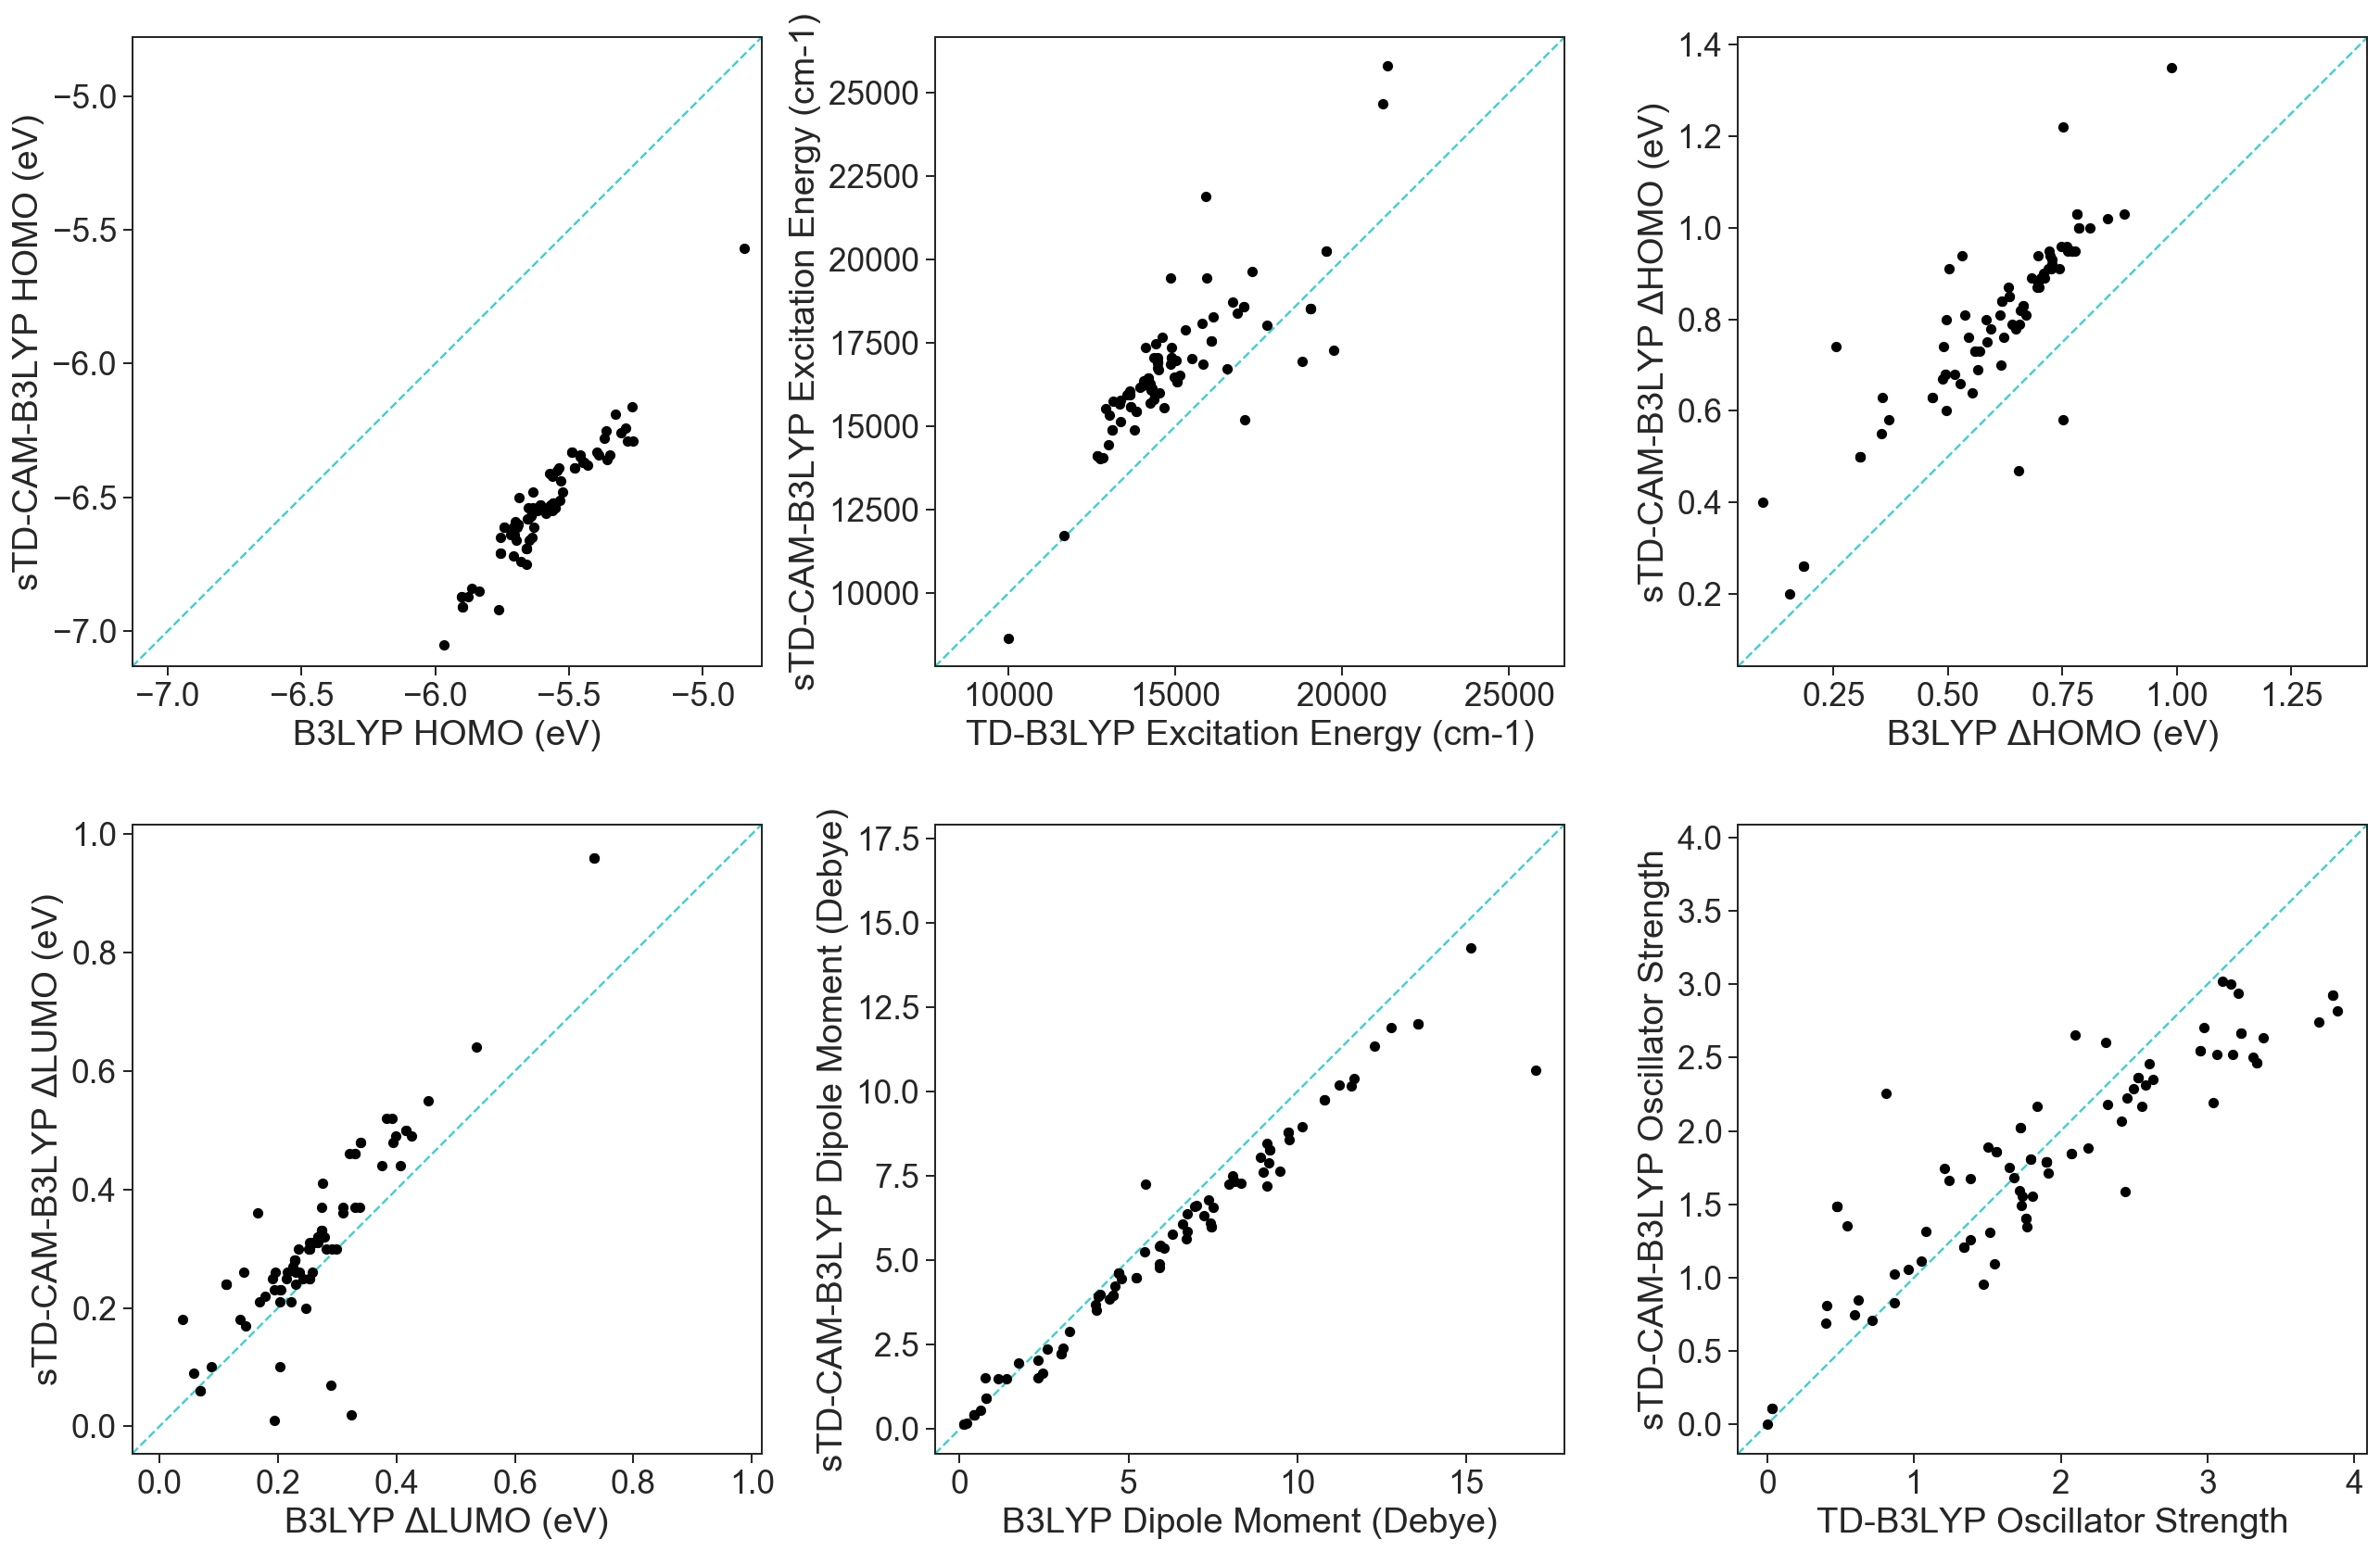

In [379]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (18, 12))

scatterplot_bigfig('AccHOMO', 'sTDDFTHOMO', df, 'B3LYP HOMO (eV)', 'sTD-CAM-B3LYP HOMO (eV)', xyline=True, ax = ax1)
scatterplot_bigfig('acc_lowest_transition_wavenumber', 'sTDDFTacclowestengtranswavenumber', df,'TD-B3LYP Excitation Energy (cm-1)', 'sTD-CAM-B3LYP Excitation Energy (cm-1)', xyline=True, ax = ax2)
scatterplot_bigfig('AccDeltaHOMO', 'sTDDFTdeltaHOMO', df,'B3LYP \u0394HOMO (eV)', 'sTD-CAM-B3LYP \u0394HOMO (eV)', xyline=True, ax=ax3)
scatterplot_bigfig('AccDeltaLUMO', 'sTDDFTdeltaLUMO', df,'B3LYP \u0394LUMO (eV)', 'sTD-CAM-B3LYP \u0394LUMO (eV)', xyline=True, ax=ax4)
scatterplot_bigfig('GSDipMom', 'sTDDFTdipolemoment', df,'B3LYP Dipole Moment (Debye)', 'sTD-CAM-B3LYP Dipole Moment (Debye)', xyline=True, ax=ax5)
scatterplot_bigfig('acc_highest_oscs_under_ten', 'sTDDFTacchighestoscsunderten', df,'TD-B3LYP Oscillator Strength', 'sTD-CAM-B3LYP Oscillator Strength', xyline=True, ax=ax6)

plt.subplots_adjust(top = 0.93, wspace = 0.3, hspace = 0.4)
plt.tight_layout()
plt.savefig('../figures/DFT_vs_sTDDFT.pdf')
plt.savefig('../figures/DFT_vs_sTDDFT.png', dpi = 300)
plt.show()